# Sample #3 - S edge

In [37]:
#https://git.aps.anl.gov/rodolakis/Macros_29id/-/blob/master/hklpy/Test_Bluesky_20210616.ipynb
# cd /home/beams/29IDUSER/Documents/User_Macros/
# %run Macros_29id/ScanFunctions_IEX.py

import databroker
from apstools.utils import listruns
from IEX_29id.utils.initialize import *
from IEX_29id.devices.detectors import *
from IEX_29id.devices.beamline_energy import *
from IEX_29id.devices.kappa_motors import *
from IEX_29id.devices.kappa_motors import kappa_motors
from IEX_29id.devices.detectors import scaler
from IEX_29id.devices.slits import slits
from IEX_29id.plans.bp_slits import *
from IEX_29id.plans.bp_energy import *
from bluesky.plans import scan
from bluesky.callbacks import LiveTable
from bluesky.callbacks.fitting import PeakStats
from bluesky.callbacks.mpl_plotting import plot_peak_stats
import matplotlib.pyplot as plt
import numpy as np

print(list(databroker.catalog))
cat=databroker.catalog['29idd'];print('Number of scans in catalog: '+str(len(cat)))



x_motor=kappa_motors.m2
y_motor=kappa_motors.m3
z_motor=kappa_motors.m4
kphi_motor=kappa_motors.m1
kap_motor=kappa_motors.m7
kth_motor=kappa_motors.m8
tth_motor=kappa_motors.m9
srs1=srs.A1
srs2=srs.A2
srs3=srs.A3
srs4=srs.A4

komega=57.322396707958816   #sample 1
komega=57.71784939933387    #sample 2
komega=57.47709960277629    #sample 3 
komega=57.35781675153791    #sample 4
komega=57.30190125169986    #sample 5
komega=57.291799999999995

scaler.stage_sigs['preset_time']=0.1

sd.baseline.append(undulator)
sd.baseline.append(mono)
sd.baseline.append(centroid_m3r)
sd.baseline.append(x_motor)
sd.baseline.append(y_motor)
sd.baseline.append(z_motor)
sd.baseline.append(tth_motor)
sd.baseline.append(kth_motor)
sd.baseline.append(kap_motor)
sd.baseline.append(kphi_motor)
sd.baseline.append(select_detector)
sd.baseline.append(srs4)
sd.baseline.append(slits)





['29idd', '29idd_retired_2021_12_01']
Number of scans in catalog: 167


In [38]:
def d4_gain():
    print('sensitivity:' ,srs.A4.sensitivity_value.get(),srs.A4.sensitivity_unit.get())
    print('gain:',srs.A4.gain.get())
    return srs.A4.gain.get()
    
def d4_input():
    print('Input Offset:', srs.A4.offset_on.get(),'-',srs.A4.offset_cal.get())
    print('Value:',srs.A4.offset_sign.get(),srs.A4.offset_fine.get())
    print('Gain:',srs.A4.offset_value.get(),srs.A4.offset_unit.get())
    # TODO: return value * gain


def gain_set(gain_value,gain_unit,n=4):
    v={1:0,2:1,5:2,10:3,20:4,50:5,100:6,200:7,500:8}[gain_value]
    u={'pA':0,'nA':1,'uA':2,'mA':4}[gain_unit]
    if n==1:
        srs1.sensitivity_unit.put(u); RE(bps.sleep(1));u=srs1.sensitivity_unit.get()
        srs1.sensitivity_value.put(v);RE(bps.sleep(1));v=srs1.sensitivity_value.get()
    elif n==2:
        srs2.sensitivity_unit.put(u); RE(bps.sleep(1));u=srs2.sensitivity_unit.get()
        srs2.sensitivity_value.put(v);RE(bps.sleep(1));v=srs2.sensitivity_value.get()
    elif n==3:
        srs3.sensitivity_unit.put(u); RE(bps.sleep(1));u=srs3.sensitivity_unit.get()
        srs3.sensitivity_value.put(v);RE(bps.sleep(1));v=srs3.sensitivity_value.get()
    elif n==4:
        srs4.sensitivity_unit.put(u); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
        srs4.sensitivity_value.put(v);RE(bps.sleep(1));v=srs4.sensitivity_value.get()
    print('SRS',n,':',v,u)
    
    
def uank(tth,kth):
    yield from bps.mv(tth_motor,tth,kth_motor,kth)
    
    
def th2th_plan(start,stop,step,offset):
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   

def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    print('npts:',npts)
    print('x_start:',x_start)
    print('x_stop:',x_stop)
    print('x_step:',x_step)
    
    
def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,x_motor,x_start,x_stop,npts)       
    
    
    
def th2th_N_plan(N,step,offset,plt=True):
    """
    N = section number
    start(N=0) = 1
    overlap=1.5
    range size = 2.25 = (55-1)/12
    """
    start=(N-1)*2.25+1
    stop=N*2.25+1+1.5
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   
    
    
def plot_latest(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    ds=cat[-1].primary.read()
    #ds.plot.scatter(x=pos.name,y=det.name)
    plt.plot(ds[pos.name], ds[det.name])
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    if log == True:
        plt.yscale('log')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
    
def plot_latest_plan(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    plot_latest(pos,det)
    yield from bps.null()

    
def plot_scatter(run,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    
    """
    ds=cat[run].primary.read()
    ds.plot.scatter(x=pos.name,y=det.name)
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    if log == True:
        plt.yscale('log')
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()

def plot_run(runlist,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    """
    A=0
    i=1
    for n in runlist:
        if isinstance(n,list):
            A=n[1]
            i=n[2]
            n=n[0]
        ds=cat[n].primary.read()
        plt.plot(ds[pos.name], ds[det.name]*i+A)
    if log:
        plt.yscale('log')
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
        
def find_z(pos=z_motor,det=D3,ds=None):
    """
    ds = cat[-1].primary.read()
    det='D3'
    pos='kappa_motors_m4'
    """
    if ds == None:
        ds = cat[-1].primary.read()
    half_intensity=float((np.max(ds[det.name])-np.min(ds[det.name]))/2)
    
    # array
    y_arr = ds[det.name]
    print("Array is : ", np.array(y_arr))

    # element to which nearest value is to be found
    y = half_intensity
    print("Value to which nearest element is to be found: ", y)

    # calculate the difference array
    difference_array = np.absolute(y_arr-y)

    # find the index of minimum element from the array
    index = difference_array.argmin()
    print("Nearest element to the given values is : ", float(y_arr[index]))
    print("Index of nearest value is : ", int(index))


    x_arr = np.array(ds[pos.name])
    print("Corresponding motor position of nearest value is : ", (x_arr[int(index)]))

        
def make_scan_list(StartStopStepLists):
    """
    Creates and returns a np.array with values based on StartStopStepList
    StartStopStepList is a list of lists defining regions for a table array
              StartStopStepList[[start1,stop1,step1],[start1,stop1,step1],...]
    Automatically removes duplicates and sorts into ascending order
    if you want descending
               myarray=XAS_Table(StartStopStepLists)[::-1]
    """
    table_array=np.array([])
    if type(StartStopStepLists) is not list:
        start=StartStopStepLists[0]
        stop=StartStopStepLists[1]
        step=StartStopStepLists[2]
        j=start
        while j<=stop:
            table_array=np.append(table_array, j)
            j+=step
    else:
        for i in range(0,len(StartStopStepLists)):
            start=StartStopStepLists[i][0]
            stop=StartStopStepLists[i][1]
            step=StartStopStepLists[i][2]
            j=start
            while j<=stop:
                table_array=np.append(table_array, j)
                j+=step
    table_array=np.unique(table_array)#removing duplicate
    table_array=np.sort(table_array) #sort into ascending order    

    return table_array.tolist()


from os import system
    

def playsound(sound='FF'):
    """
    plays a sound when run
    'FF' Final Fantasy victory sound
    'ding' a subtle ding noise
    'hallelujah' hallelujah chorus
    """
    if sound == 'FF':
        sounds = '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav'
    elif sound == 'ding':
        sounds = '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/ding.wav'
    elif sound == 'hallelujah':
        sounds = '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/hallelujah.wav'
    system('aplay ' + sounds)


In [131]:
def plot_reflectivity(run_list=[-1,-2], pos=tth_motor,det=D4):
    for n in run_list:
        g=cat[n].baseline.read()[srs.A4.name][0]
        ds=cat[n].primary.read()
        plt.plot(ds[pos.name], ds[det.name]*g)
    plt.yscale('log')
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
    
    
def align_z():
    yield from bp.rel_scan([scaler],z_motor,-750,750,51)
    
    
def align_tth(window=0.25,npts=51):
    yield from bp.rel_scan([scaler],tth_motor,-window,window,npts)
        
    
def align_kth(window=0.25,npts=51):
    yield from bp.rel_scan([scaler],kth_motor,-window,window,npts)

In [179]:

komega=57.322396707958816   #sample 1
komega=57.71784939933387    #sample 2
komega=57.47709960277629    #sample 3 
komega=57.35781675153791    #sample 4
komega=57.30190125169986    #sample 5
komega=57.291799999999995

scaler.stage_sigs['preset_time']=0.1

In [ ]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))



Transient Scan ID: 127     Time: 2021-12-05 12:37:34
Persistent Unique Scan ID: '6b793ca4-1ad4-4194-8b33-d411e79be797'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6656692028045654             |
|                    mono_energy | 679.9923553                    |
|              mono_mirror_pitch | 3.1785900878906252             |
|             mono_grating_pitch | 4.309100317382812              |
|                    centroidM3R | 112.58737579483788             |
|                kappa_motors_m2 | -0.354                         |
|                kappa_motors_m3 | 0.053                          |
|                kappa_motors_m4 | 0.108                          |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.755                        |
|       

('6b793ca4-1ad4-4194-8b33-d411e79be797',)

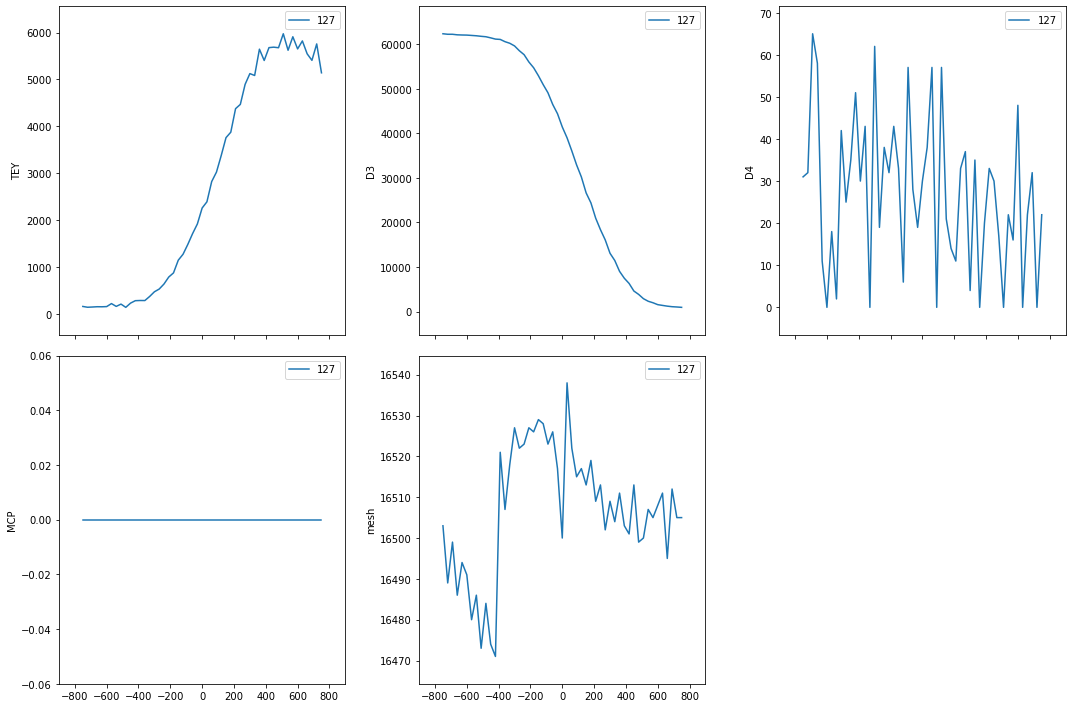

In [5]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))

In [6]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [7]:
find_z()

Array is :  [62351. 62237. 62233. 62113. 62072. 62050. 61975. 61898. 61778. 61680.
 61431. 61152. 61080. 60573. 60216. 59620. 58545. 57657. 56019. 54721.
 52930. 50936. 49102. 46481. 44400. 41433. 38998. 36047. 32906. 30206.
 26621. 24389. 20953. 18367. 16070. 13076. 11449.  9014.  7465.  6296.
  4599.  3838.  2881.  2302.  1966.  1539.  1369.  1202.  1081.  1015.
   935.]
Value to which nearest element is to be found:  30708.0
Nearest element to the given values is :  30206.0
Index of nearest value is :  29
Corresponding motor position of nearest value is :  1.20108e+02


In [19]:
RE(mvz(120))

()

# Direct beam vs m3r

### 1 pixel  ~ 0.01 degree on D4



Transient Scan ID: 128     Time: 2021-12-05 12:40:54
Persistent Unique Scan ID: '3629e884-077b-4daa-b170-86638e7f030e'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6655617356300354             |
|                    mono_energy | 680.0095413                    |
|              mono_mirror_pitch | 3.1785650634765625             |
|             mono_grating_pitch | 4.309102758789063              |
|                    centroidM3R | 111.04725206058262             |
|                kappa_motors_m2 | -0.355                         |
|                kappa_motors_m3 | 0.031                          |
|                kappa_motors_m4 | -1000.287                      |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.755                        |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6656692028045654             |
|                    mono_energy | 679.9972577                    |
|              mono_mirror_pitch | 3.1786260986328125             |
|             mono_grating_pitch | 4.30912900390625               |
|                    centroidM3R | 111.11239210478662             |
|                kappa_motors_m2 | -0.356                         |
|                kappa_motors_m3 | 0.024                          |
|                kappa_motors_m4 | -1000.2950000000001            |
|                kappa_motors_m9 | 0.25                           |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.044896679999994             |
|                select_detector | d4                             |
|         motors_H

('3629e884-077b-4daa-b170-86638e7f030e',)

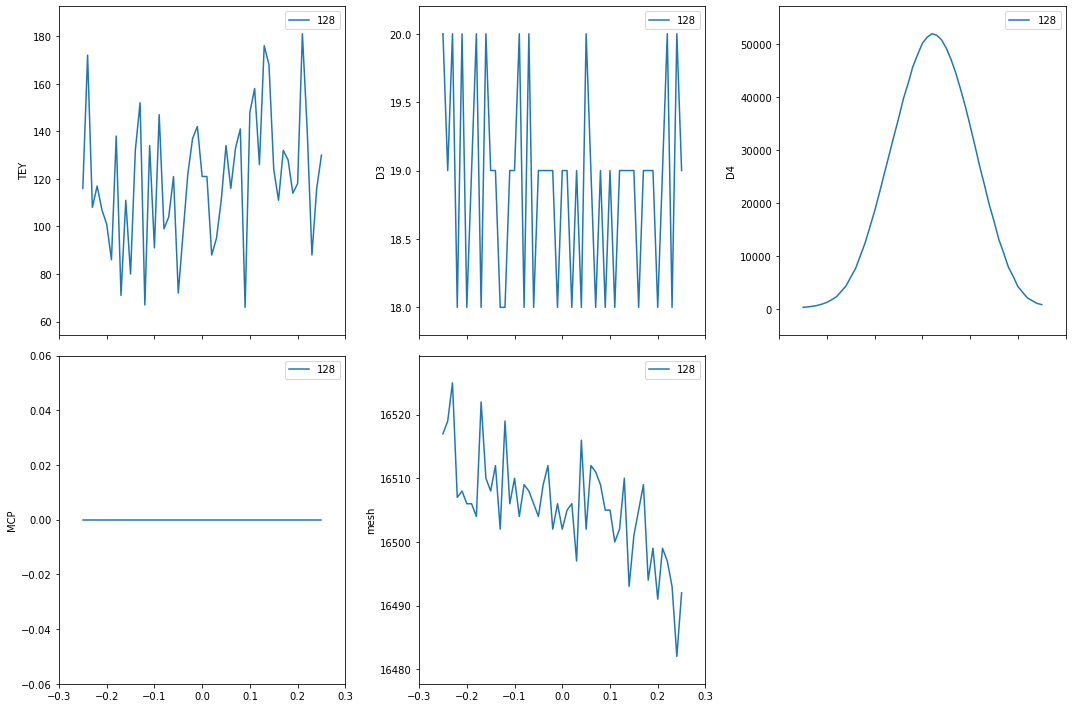

In [10]:
RE(bp.rel_scan([scaler],tth_motor,-0.25,0.25,51))

In [11]:
peaks

{
'com':
    {'D3': -0.0006334371754932629,
     'D4': 0.020905001451987034,
     'MCP': nan,
     'TEY': 0.008710099852676371,
     'mesh': -4.886086355309488e-05}
,
'cen':
    {'D3': -0.0581578947368421,
     'D4': 0.02209326366959262,
     'MCP': None,
     'TEY': -0.0010650514953614468,
     'mesh': 0.036541663390502396}
,
'max':
    {'D3': (-0.25,
            20.0),
     'D4': (0.02,
            52024.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.21,
             181.0),
     'mesh': (-0.23,
              16525.0)}
,
'min':
    {'D3': (-0.22,
            18.0),
     'D4': (-0.25,
            326.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.09,
             66.0),
     'mesh': (0.24,
              16482.0)}
,
'fwhm':
    {'D3': 0.49,
     'D4': 0.20041529291109916,
     'MCP': None,
     'TEY': 0.4940178571428572,
     'mesh': 0.3051666666666667}
,
}



Transient Scan ID: 129     Time: 2021-12-05 12:44:24
Persistent Unique Scan ID: 'b8a05e6c-8205-4653-a3f9-ae3c696e4fe7'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 680.0020788                    |
|              mono_mirror_pitch | 3.1786187744140624             |
|             mono_grating_pitch | 4.309090551757812              |
|                    centroidM3R | 111.83238746677021             |
|                kappa_motors_m2 | -0.356                         |
|                kappa_motors_m3 | 0.028                          |
|                kappa_motors_m4 | -1000.315                      |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|       

('b8a05e6c-8205-4653-a3f9-ae3c696e4fe7',)

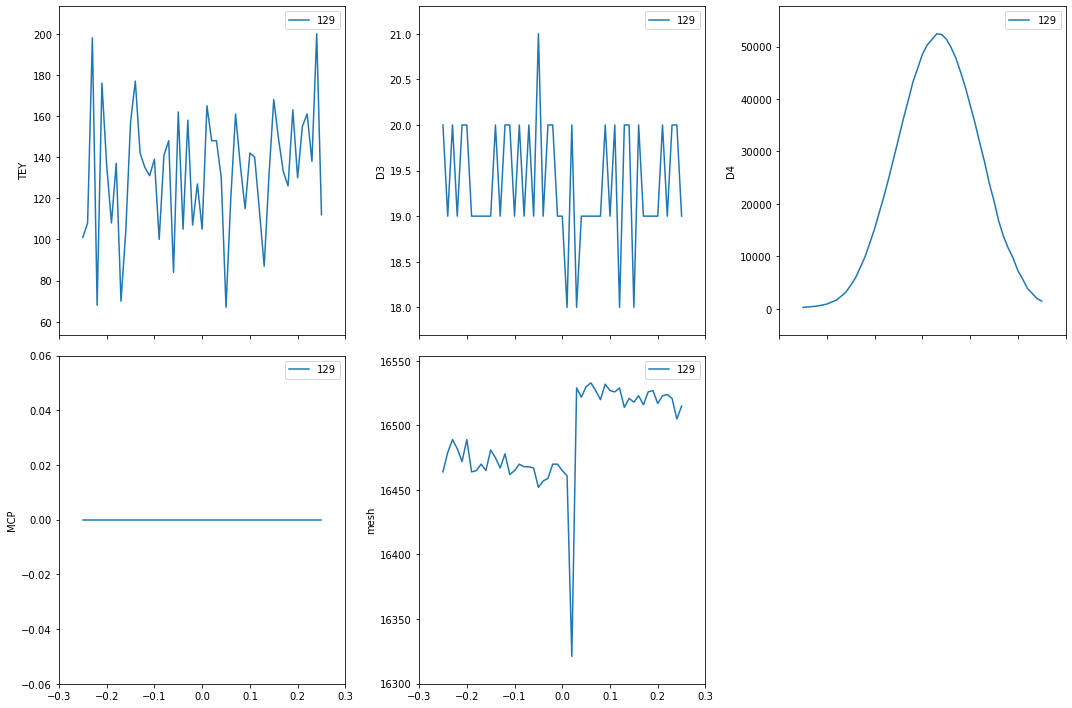

In [12]:
RE(bp.rel_scan([scaler],tth_motor,-0.25,0.25,51))

In [13]:
peaks

{
'com':
    {'D3': -0.0005572441742654633,
     'D4': 0.03249324071039094,
     'MCP': nan,
     'TEY': 0.00595297944699098,
     'mesh': 0.0001816484744714586}
,
'cen':
    {'D3': -0.005645161290322579,
     'D4': 0.0338379851986912,
     'MCP': None,
     'TEY': -0.017256782094002904,
     'mesh': 0.018762362637362636}
,
'max':
    {'D3': (-0.05,
            21.0),
     'D4': (0.03,
            52441.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.24,
             200.0),
     'mesh': (0.06,
              16533.0)}
,
'min':
    {'D3': (0.01,
            18.0),
     'D4': (-0.25,
            286.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.05,
             67.0),
     'mesh': (0.02,
              16321.0)}
,
'fwhm':
    {'D3': 0.49,
     'D4': 0.2007564489183177,
     'MCP': None,
     'TEY': 0.4847234848484848,
     'mesh': 0.012667582417582417}
,
}

In [14]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo




Transient Scan ID: 130     Time: 2021-12-05 12:46:29
Persistent Unique Scan ID: '978df03d-7f23-488f-9f2d-af3cd73514ea'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9994557                    |
|              mono_mirror_pitch | 3.1786102294921874             |
|             mono_grating_pitch | 4.30910458984375               |
|                    centroidM3R | 110.66407897689028             |
|                kappa_motors_m2 | -0.357                         |
|                kappa_motors_m3 | 0.025                          |
|                kappa_motors_m4 | -1000.318                      |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|       

('978df03d-7f23-488f-9f2d-af3cd73514ea',)

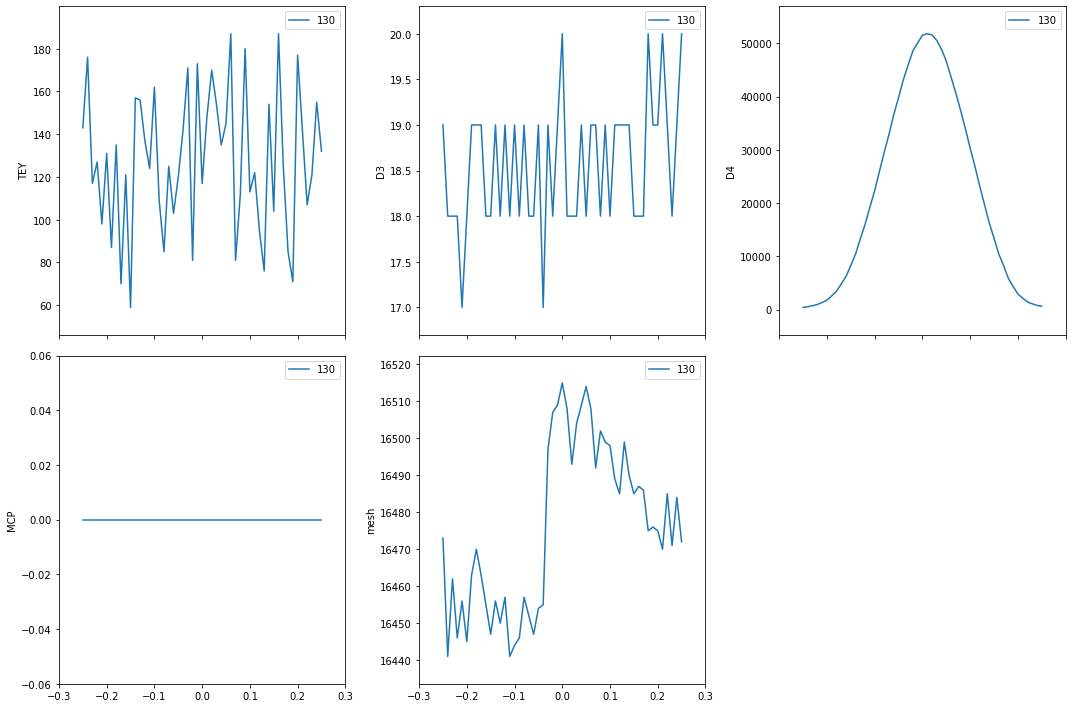

In [16]:
RE(bp.rel_scan([scaler],tth_motor,-0.25,0.25,51))

In [17]:
peaks

{
'com':
    {'D3': 0.0019218585005279822,
     'D4': 0.009916172357341609,
     'MCP': nan,
     'TEY': 0.0020464329643296608,
     'mesh': 0.00011048908438301198}
,
'cen':
    {'D3': -0.013571428571428571,
     'D4': 0.011292693765416466,
     'MCP': None,
     'TEY': -0.015629730735120768,
     'mesh': 0.17724447774447774}
,
'max':
    {'D3': (0.0,
            20.0),
     'D4': (0.01,
            51821.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.06,
             187.0),
     'mesh': (0.0,
              16515.0)}
,
'min':
    {'D3': (-0.21,
            17.0),
     'D4': (-0.25,
            408.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (-0.15,
             59.0),
     'mesh': (-0.24,
              16441.0)}
,
'fwhm':
    {'D3': 0.48,
     'D4': 0.20179672629030526,
     'MCP': None,
     'TEY': 0.46160518444666004,
     'mesh': 0.2795238095238095}
,
}

In [18]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


### Specular

In [20]:
RE(uank(30,15+57))

()



Transient Scan ID: 131     Time: 2021-12-05 12:51:58
Persistent Unique Scan ID: '5833dcaf-fc75-4b6d-92c2-fc4824f08c89'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9776122                    |
|              mono_mirror_pitch | 3.1785614013671877             |
|             mono_grating_pitch | 4.309096044921875              |
|                    centroidM3R | 111.72079419879091             |
|                kappa_motors_m2 | -0.35100000000000003           |
|                kappa_motors_m3 | 0.022                          |
|                kappa_motors_m4 | 120.084                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.00014238179003              |
|                kappa_motors_m7 | 134.75600000000003             |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9992296                    |
|              mono_mirror_pitch | 3.178657836914063              |
|             mono_grating_pitch | 4.30910703125                  |
|                    centroidM3R | 111.72484799472849             |
|                kappa_motors_m2 | -0.35100000000000003           |
|                kappa_motors_m3 | 0.017                          |
|                kappa_motors_m4 | 120.08800000000001             |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.50114238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04487652                    |
|                select_detector | d4                             |
|         motors_H

('5833dcaf-fc75-4b6d-92c2-fc4824f08c89',)

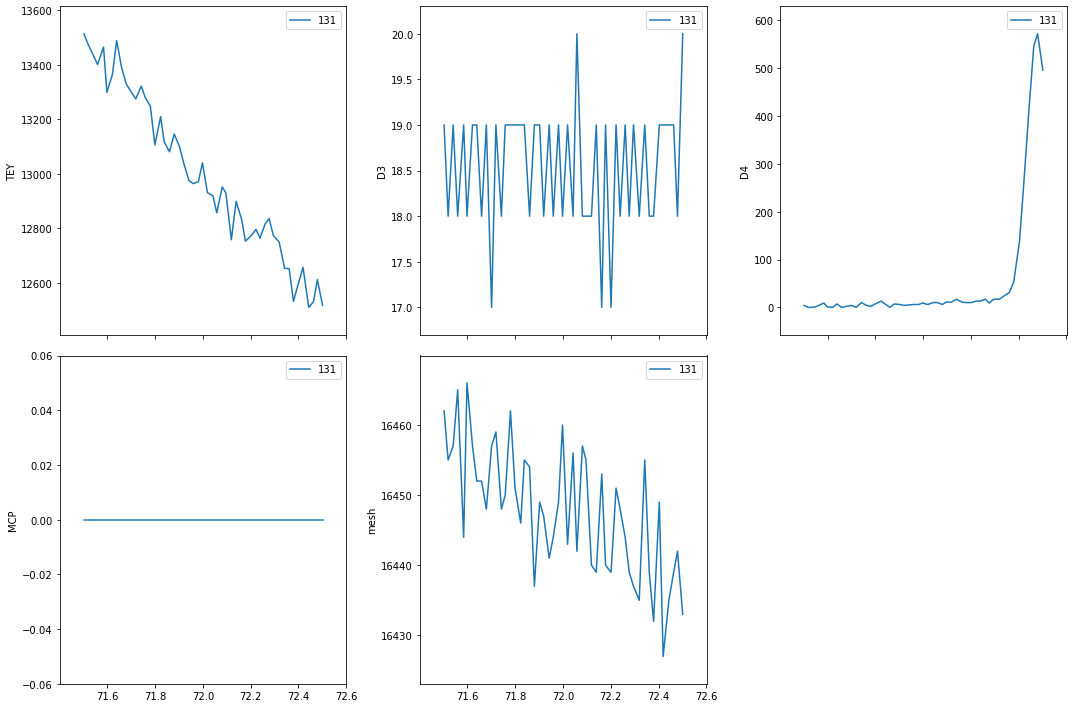

In [21]:
RE(bp.rel_scan([scaler],kth_motor,-0.5,0.5,51))

In [22]:
peaks

{
'com':
    {'D3': 71.99838656783653,
     'D4': 72.41313105034526,
     'MCP': nan,
     'TEY': 71.99259260375146,
     'mesh': 71.99804840752091}
,
'cen':
    {'D3': 71.98455027652685,
     'D4': 72.42514238179001,
     'MCP': None,
     'TEY': 71.97467638355477,
     'mesh': 72.04803729216093}
,
'max':
    {'D3': (72.05814238179002,
            20.0),
     'D4': (72.47914238179001,
            572.0),
     'MCP': (71.50214238179001,
             0.0),
     'TEY': (71.50214238179001,
             13514.0),
     'mesh': (71.59814238179001,
              16466.0)}
,
'min':
    {'D3': (71.70114238179002,
            17.0),
     'D4': (71.51914238179,
            0.0),
     'MCP': (71.50214238179001,
             0.0),
     'TEY': (72.44314238179001,
             12510.0),
     'mesh': (72.41914238179001,
              16427.0)}
,
'fwhm':
    {'D3': 0.9740000000000038,
     'D4': None,
     'MCP': None,
     'TEY': 0.07428843480678893,
     'mesh': 0.8237943722943868}
,
}

In [23]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [25]:
peaks['max']['D4']

(72.47914238179001, 572.0)

In [26]:
RE(mvkth(peaks['max']['D4'][0]))

()



Transient Scan ID: 132     Time: 2021-12-05 12:54:25
Persistent Unique Scan ID: 'a44a2ed9-1c87-47be-887b-553f04f763a9'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 680.013449                     |
|              mono_mirror_pitch | 3.1786511230468752             |
|             mono_grating_pitch | 4.309118017578125              |
|                    centroidM3R | 111.7843096077402              |
|                kappa_motors_m2 | -0.35000000000000003           |
|                kappa_motors_m3 | 0.015                          |
|                kappa_motors_m4 | 120.093                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.47914238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 680.00131                      |
|              mono_mirror_pitch | 3.178641357421875              |
|             mono_grating_pitch | 4.309125952148437              |
|                    centroidM3R | 111.90228857500448             |
|                kappa_motors_m2 | -0.35100000000000003           |
|                kappa_motors_m3 | 0.019                          |
|                kappa_motors_m4 | 120.099                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.98114238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04488048                    |
|                select_detector | d4                             |
|         motors_H

('a44a2ed9-1c87-47be-887b-553f04f763a9',)

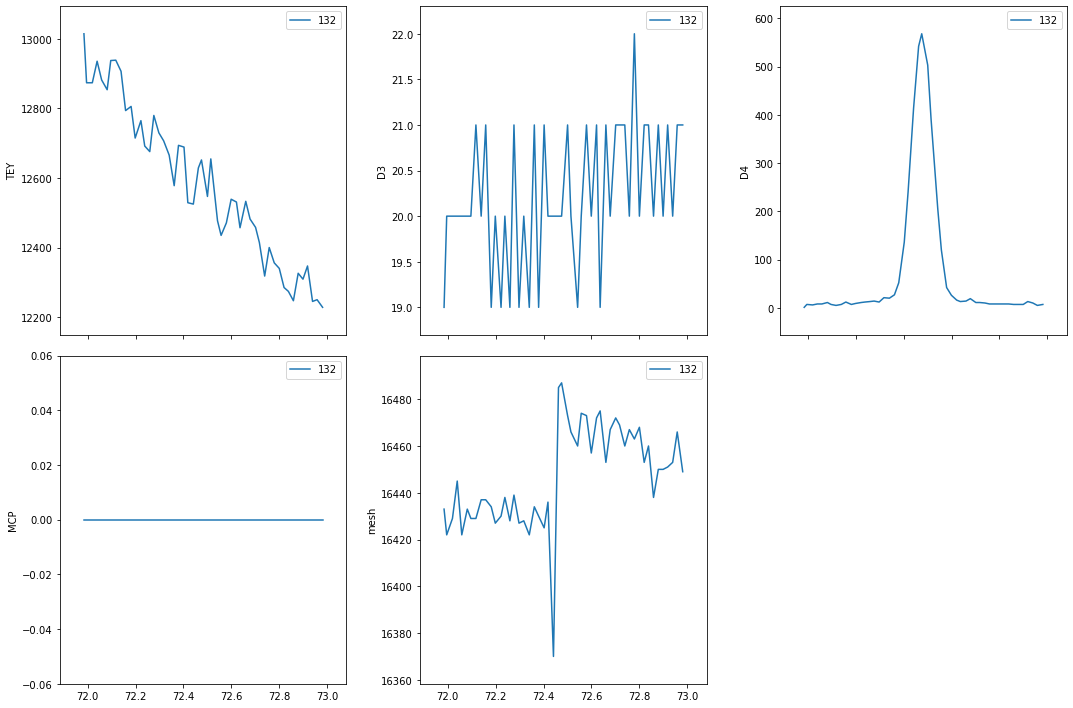

In [27]:
RE(bp.rel_scan([scaler],kth_motor,-0.5,0.5,51))

In [29]:
peaks

{
'com':
    {'D3': 72.48081648460283,
     'D4': 72.47453640427426,
     'MCP': nan,
     'TEY': 72.4718942150013,
     'mesh': 72.47540606361932}
,
'cen':
    {'D3': 72.57029755420382,
     'D4': 72.47709960277629,
     'MCP': None,
     'TEY': 72.44282722038938,
     'mesh': 72.24036553053568}
,
'max':
    {'D3': (72.77914238179002,
            22.0),
     'D4': (72.47514238179002,
            568.0),
     'MCP': (71.98414238179001,
             0.0),
     'TEY': (71.98414238179001,
             13015.0),
     'mesh': (72.47514238179002,
              16487.0)}
,
'min':
    {'D3': (71.98414238179001,
            19.0),
     'D4': (71.98414238179001,
            1.0),
     'MCP': (71.98414238179001,
             0.0),
     'TEY': (72.98114238179002,
             12228.0),
     'mesh': (72.44114238179003,
              16370.0)}
,
'fwhm':
    {'D3': 0.842000000000013,
     'D4': 0.10615007415647426,
     'MCP': None,
     'TEY': 0.16865034473953244,
     'mesh': 0.46318260869567496}
,

In [28]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [32]:
peaks['cen']['D4']

72.47709960277629

In [34]:
komega=peaks['cen']['D4']-15

In [35]:
komega

57.47709960277629

In [63]:
komega-57.045

0.4320996027762902

In [40]:
RE(uank(2,1+komega))

()

sensitivity: 1 uA/V
gain: 1e-06


Transient Scan ID: 133     Time: 2021-12-05 13:02:27
Persistent Unique Scan ID: '093c589e-2d99-47a8-adbf-91ba84a6c18e'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6655617356300354             |
|                    mono_energy | 680.0019793                    |
|              mono_mirror_pitch | 3.1786065673828126             |
|             mono_grating_pitch | 4.309078955078125              |
|                    centroidM3R | 113.03742557414233             |
|                kappa_motors_m2 | -0.356                         |
|                kappa_motors_m3 | 0.03                           |
|                kappa_motors_m4 | 120.10600000000001             |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.47714238179                 |
|                kappa_motors_m7 | 134.75600

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9865393                    |
|              mono_mirror_pitch | 3.1786120605468753             |
|             mono_grating_pitch | 4.30909482421875               |
|                    centroidM3R | 113.47944490039544             |
|                kappa_motors_m2 | 6105.032                       |
|                kappa_motors_m3 | 0.024                          |
|                kappa_motors_m4 | 120.104                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.47714238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04482648                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.5, success=True, settle_time=0.0)

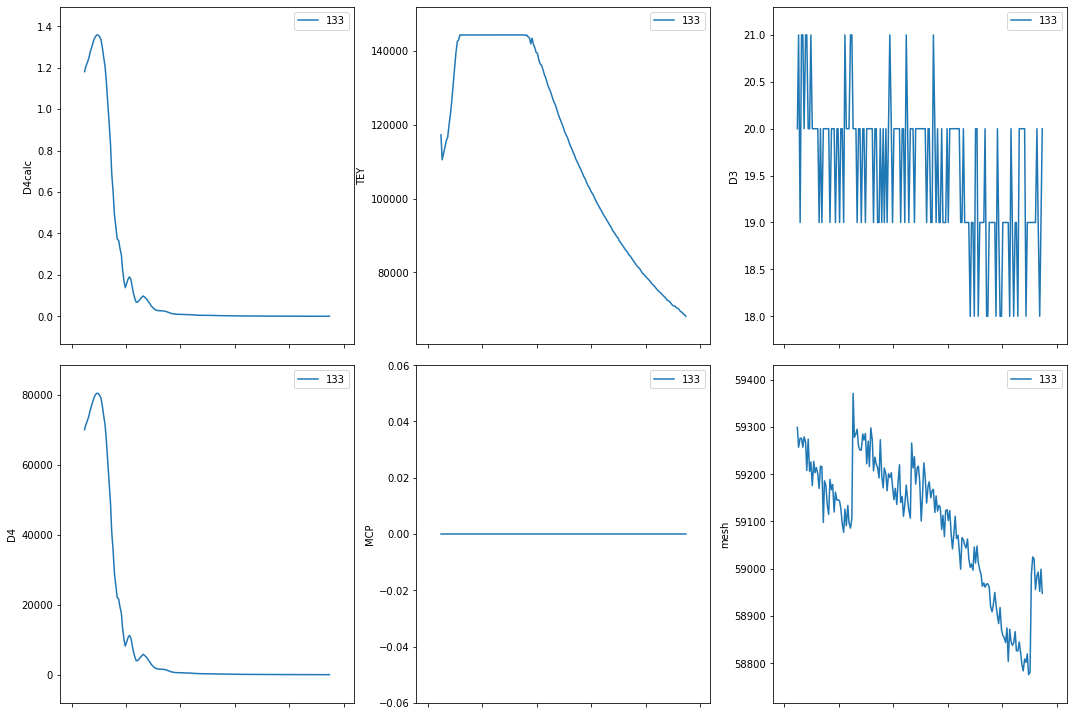

In [42]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,5200,5,komega)); slits.V4size.move(0)

In [43]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


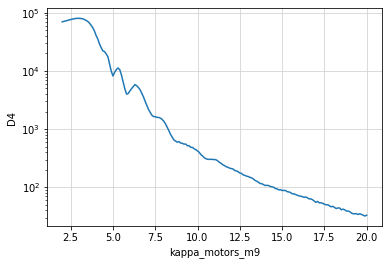

In [44]:
plot_latest(tth_motor,D4,log=True)

In [45]:
RE(uank(14,7+komega))

()

sensitivity: 1 nA/V
gain: 1e-09


Transient Scan ID: 134     Time: 2021-12-05 13:10:08
Persistent Unique Scan ID: '445bbd9f-02ba-4cf6-bcfd-46725f3df138'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6655617356300354             |
|                    mono_energy | 679.9982165                    |
|              mono_mirror_pitch | 3.1786517333984374             |
|             mono_grating_pitch | 4.309114965820313              |
|                    centroidM3R | 113.74639113952279             |
|                kappa_motors_m2 | 6105.086                       |
|                kappa_motors_m3 | -0.003                         |
|                kappa_motors_m4 | 120.10900000000001             |
|                kappa_motors_m9 | 16.0                           |
|                kappa_motors_m8 | 65.47714238179                 |
|                kappa_motors_m7 | 134.75600

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


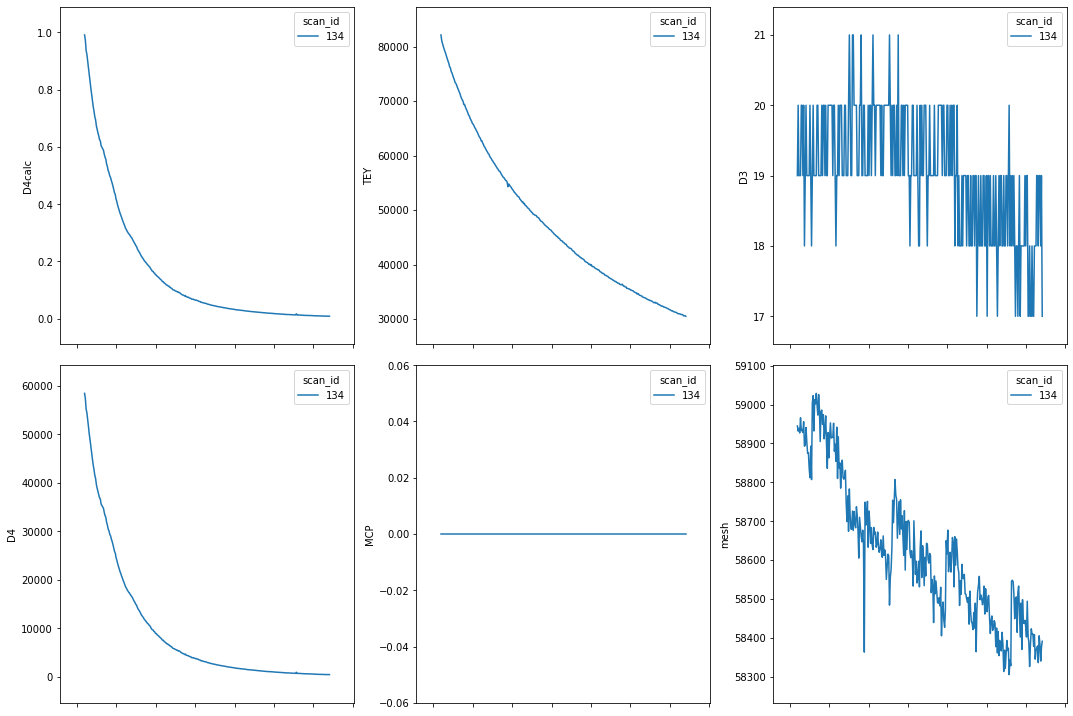

In [46]:
g=d4_gain()
slits.V4size.move(300)
RE(th2thx_plan(8,28,0.05,5800,-5,komega))
slits.V4size.move(0)

In [ ]:
playsound()

In [47]:
RE.stop()

Stopping: running cleanup and marking exit_status as 'success'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['445bbd9f'] (scan num: 134)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 680.0035622                    |
|              mono_mirror_pitch | 3.178619384765625              |
|             mono_grating_pitch | 4.309113134765625              |
|                    centroidM3R | 114.20351358197613             |
|                kappa_motors_m2 | 4241.039                       |
|                kappa_motors_m3 | -0.024                         |
|                kappa_motors_m4 | 120.12700000000001             |
|                kappa_motors_m9 | 47.1                           |
|                kappa_motors_m8 | 81.02714238179001              |
|                kappa_motors_m7 | 134.757                        |
|                kappa_motors_m1 | 57.04533408                    |
|                select_detector | d4                             |
|         motors_H

('445bbd9f-02ba-4cf6-bcfd-46725f3df138',)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


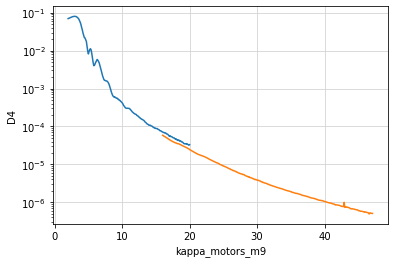

In [48]:
plot_run([[133,0,1e-06],[134,0,1e-09]],tth_motor,D4,log=True)

In [57]:
gain_set(5,'nA')

SRS 4 : 5 nA/V


# Fresh spot:

In [ ]:
slits.V4size.move(0)

In [58]:
RE(uank(2,1+komega))

()

In [59]:
gain_set(200,'nA')

SRS 4 : 200 nA/V


sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


Transient Scan ID: 135     Time: 2021-12-05 13:32:17
Persistent Unique Scan ID: 'c8e40dc1-d5eb-4eef-861d-1a12708e0c83'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9972215                    |
|              mono_mirror_pitch | 3.17865478515625               |
|             mono_grating_pitch | 4.309112524414062              |
|                    centroidM3R | 111.85981308411215             |
|                kappa_motors_m2 | 4240.97                        |
|                kappa_motors_m3 | 0.003                          |
|                kappa_motors_m4 | 120.126                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.47714238179                 |
|                kappa_mo

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 680.0012919                    |
|              mono_mirror_pitch | 3.178638916015625              |
|             mono_grating_pitch | 4.309120458984375              |
|                    centroidM3R | 111.69937106918239             |
|                kappa_motors_m2 | 3094.945                       |
|                kappa_motors_m3 | -0.012                         |
|                kappa_motors_m4 | 120.14                         |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.47714238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04532363999999              |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.5, success=True, settle_time=0.0)

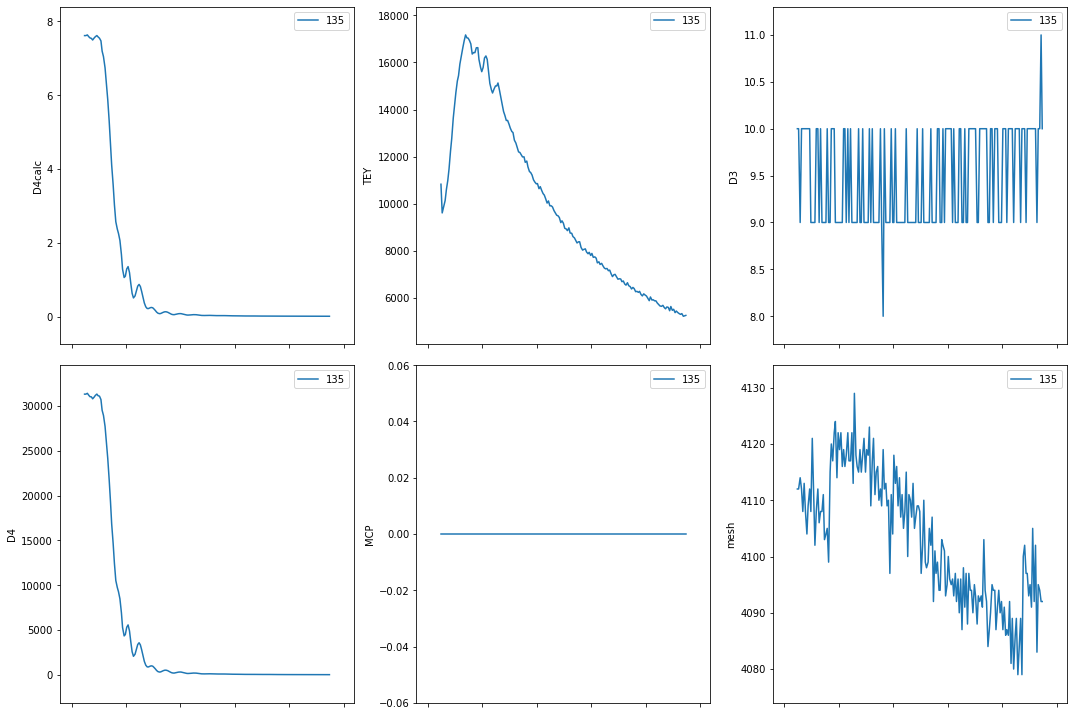

In [64]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,4000,-5,komega)); slits.V4size.move(0)

In [65]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


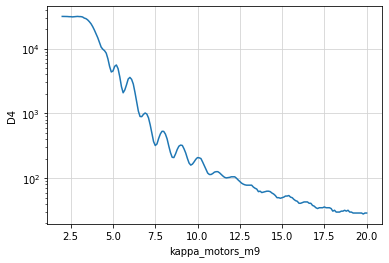

In [66]:
plot_latest(tth_motor,D4,log=True)

In [67]:
gain_set(1,'nA')

SRS 4 : 1 nA/V


sensitivity: 1 nA/V
gain: 1e-09


Transient Scan ID: 136     Time: 2021-12-05 13:37:44
Persistent Unique Scan ID: '6e40690b-29d3-499b-9848-2bc9ce489ed3'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9955391                    |
|              mono_mirror_pitch | 3.178648681640625              |
|             mono_grating_pitch | 4.309106420898438              |
|                    centroidM3R | 112.24728588661037             |
|                kappa_motors_m2 | 3094.896                       |
|                kappa_motors_m3 | -0.013000000000000001          |
|                kappa_motors_m4 | 120.139                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.47714238179                 |
|                kappa_motors_m7 | 134.75600

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9919301                    |
|              mono_mirror_pitch | 3.1785980224609376             |
|             mono_grating_pitch | 4.3090875                      |
|                    centroidM3R | 112.43363994743758             |
|                kappa_motors_m2 | 1594.945                       |
|                kappa_motors_m3 | -0.019                         |
|                kappa_motors_m4 | 120.15                         |
|                kappa_motors_m9 | 40.0                           |
|                kappa_motors_m8 | 77.47714238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04534524                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

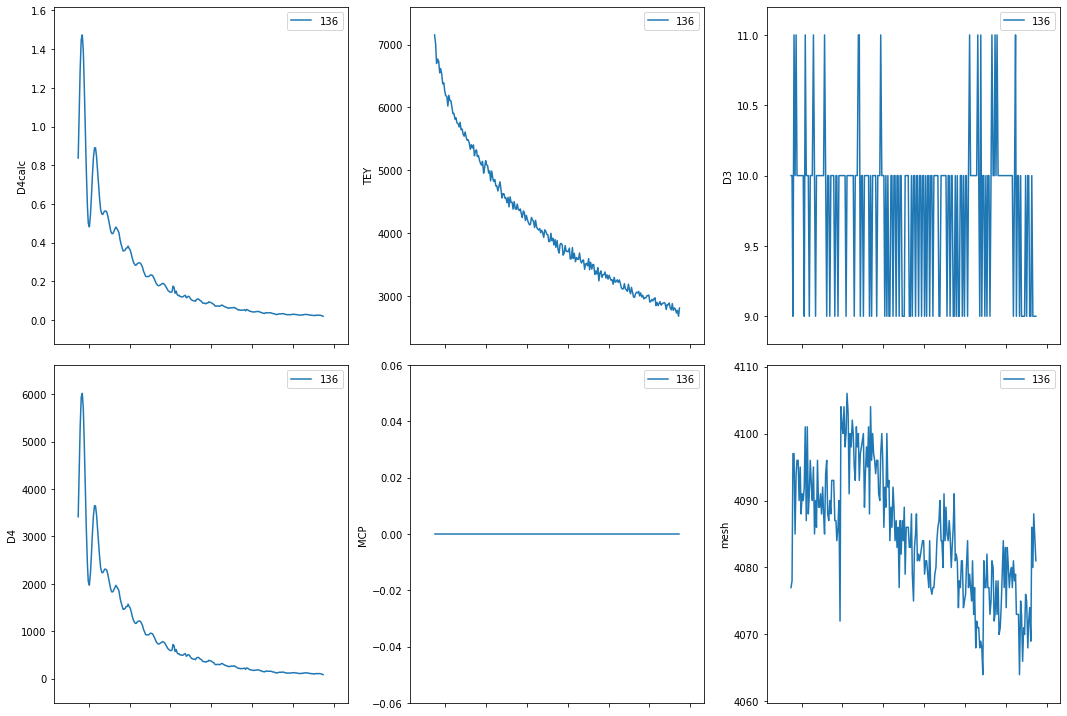

In [68]:
g=d4_gain()
slits.V4size.move(300)
RE(th2thx_plan(8,20,0.05,2800,-5,komega))
slits.V4size.move(0)

In [69]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


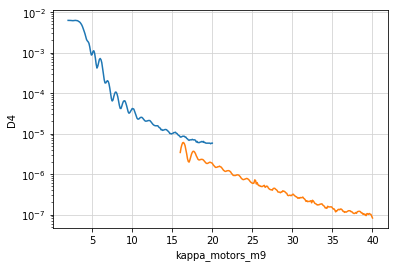

In [71]:
plot_resitivity()

# E = 691 eV

In [5]:
id_calc(1200,'RCP',555)

MEG 0 555


5.688e-01

In [6]:
grt= mono.grating_density.value
id_calc('MEG',0,555)

MEG 0 555


5.688e-01

In [14]:
mode=v.get()

In [15]:
mode

2

()

In [5]:
RE(energy_plan(691))

MEG 2 691
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.Deferred pause acknowledged. Continuing to checkpoint.

trying a second time
Pausing...


RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


In [6]:
RE.abort() 

Aborting: running cleanup and marking exit_status as 'abort'...


Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1479, in _run
    msg = self._plan_stack[-1].throw(
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 78, in plan_mutator
    msg = plan_stack[-1].throw(exception)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/py

()

In [5]:
RE(slitBL_set(0.5))

()

In [6]:
RE(uank(2,1+komega))

()

In [7]:
th2thx_plan_test(1,10,0.05,1400,-5,komega)

npts: 181
x_start: 1400
x_stop: 495
x_step: -5


In [9]:
d4_gain()

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


5.000000000000001e-07

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


Transient Scan ID: 137     Time: 2021-12-05 14:58:29
Persistent Unique Scan ID: 'd04c2032-c620-43ef-874b-fcf7ab143744'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6769866347312927             |
|                    mono_energy | 691.0013139                    |
|              mono_mirror_pitch | 3.153133544921875              |
|             mono_grating_pitch | 4.274638647460938              |
|                    centroidM3R | 110.58734288311445             |
|                kappa_motors_m2 | 1594.861                       |
|                kappa_motors_m3 | -0.017                         |
|                kappa_motors_m4 | 120.16                         |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.47714238179                 |
|                kappa_mot

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6772068738937378             |
|                    mono_energy | 691.0030699                    |
|              mono_mirror_pitch | 3.1531768798828126             |
|             mono_grating_pitch | 4.274630102539063              |
|                    centroidM3R | 110.6536160451347              |
|                kappa_motors_m2 | 495.00100000000003             |
|                kappa_motors_m3 | -0.028                         |
|                kappa_motors_m4 | 120.167                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.47714238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045324359999995             |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

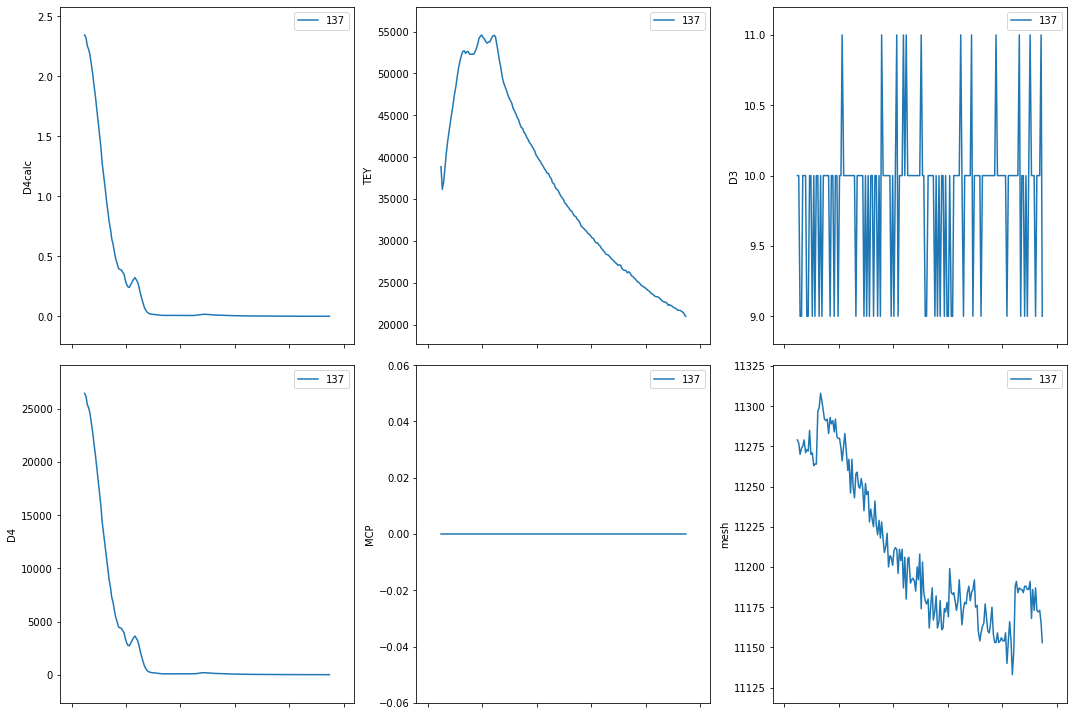

In [10]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,1400,-5,komega)); slits.V4size.move(0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


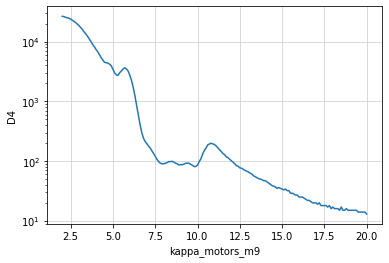

In [11]:
plot_latest(tth_motor,D4,log=True)

In [13]:
RE(uank(10.8,5.4+komega))

()

In [14]:
RE(uank(8.8,4.4+komega))

()

In [15]:
RE(uank(9,4.5+komega))

()

In [16]:
th2thx_plan_test(9,20,0.05,500,-5,komega)

npts: 221
x_start: 500
x_stop: -605
x_step: -5


sensitivity: 5 nA/V
gain: 5e-09


Transient Scan ID: 138     Time: 2021-12-05 15:09:03
Persistent Unique Scan ID: '05c1cf41-9159-4260-a955-5ed7b4257b14'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6769866347312927             |
|                    mono_energy | 690.9993805                    |
|              mono_mirror_pitch | 3.1531390380859374             |
|             mono_grating_pitch | 4.274608740234375              |
|                    centroidM3R | 111.31158665530411             |
|                kappa_motors_m2 | 494.926                        |
|                kappa_motors_m3 | -0.019                         |
|                kappa_motors_m4 | 120.168                        |
|                kappa_motors_m9 | 9.0                            |
|                kappa_motors_m8 | 61.97714238179                 |
|                kappa_motors_m7 | 134.75600

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


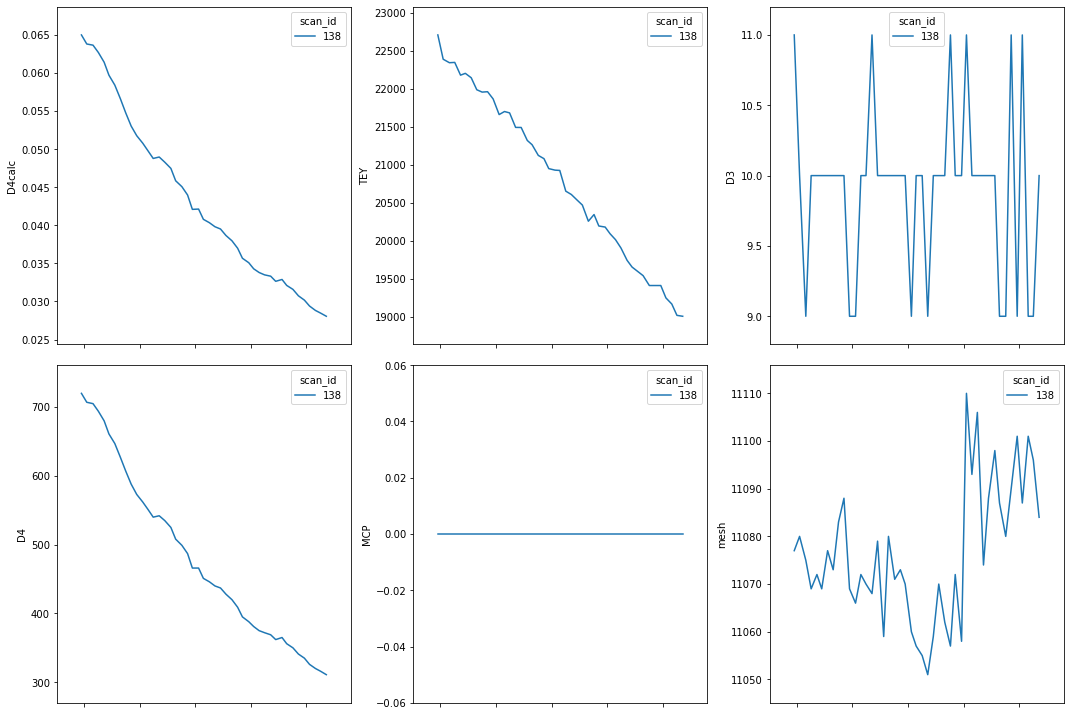

In [18]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(9,30,0.05,-200,-5,komega)); slits.V4size.move(0)

In [19]:
RE.stop()  

Stopping: running cleanup and marking exit_status as 'success'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['05c1cf41'] (scan num: 138)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6773170232772827             |
|                    mono_energy | 690.9987921                    |
|              mono_mirror_pitch | 3.1531964111328126             |
|             mono_grating_pitch | 4.274636206054687              |
|                    centroidM3R | 111.12277258566978             |
|                kappa_motors_m2 | -420.58500000000004            |
|                kappa_motors_m3 | -0.028                         |
|                kappa_motors_m4 | 120.173                        |
|                kappa_motors_m9 | 22.400000000000002             |
|                kappa_motors_m8 | 68.67714238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04533984                    |
|                select_detector | d4                             |
|         motors_H

('05c1cf41-9159-4260-a955-5ed7b4257b14',)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


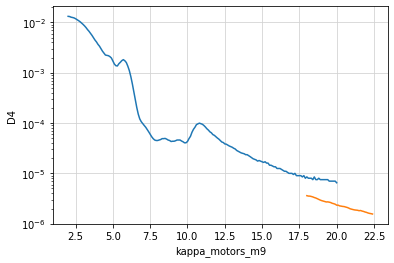

In [21]:
plot_reflectivity()

In [23]:
RE(uank(4,8+komega))

()

In [20]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(4.5,20,0.05,-600,-5,komega)); slits.V4size.move(0)

sensitivity: 1 nA/V
gain: 1e-09


Transient Scan ID: 144     Time: 2021-12-05 16:48:18
Persistent Unique Scan ID: '11d95e35-95a7-4af2-bc95-22353c9336a2'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6810774803161621             |
|                    mono_energy | 695.0048148                    |
|              mono_mirror_pitch | 3.1440380859375                |
|             mono_grating_pitch | 4.262296728515625              |
|                    centroidM3R | 110.72337147887323             |
|                kappa_motors_m2 | -0.128                         |
|                kappa_motors_m3 | 0.02                           |
|                kappa_motors_m4 | -30.087                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.09614238179                 |
|                kappa_motors_m7 | 134.76   

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


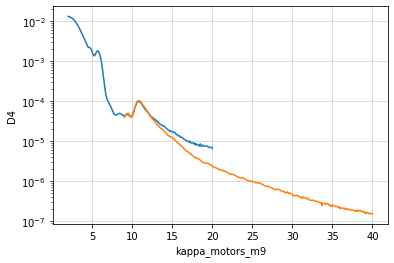

In [26]:
plot_reflectivity(-1,-3)

In [28]:
RE(uank(20,10+komega))

()

In [29]:
d4_gain()

sensitivity: 100 pA/V
gain: 1e-10


1e-10

In [30]:
RE(uank(19,9.5+komega))

()

sensitivity: 100 pA/V
gain: 1e-10


Transient Scan ID: 140     Time: 2021-12-05 15:38:04
Persistent Unique Scan ID: '92a8fbc8-e075-4729-bb2a-9dbd39c78d44'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6772068738937378             |
|                    mono_energy | 691.0115884                    |
|              mono_mirror_pitch | 3.153150634765625              |
|             mono_grating_pitch | 4.27462705078125               |
|                    centroidM3R | 112.11852040653774             |
|                kappa_motors_m2 | -2155.1240000000003            |
|                kappa_motors_m3 | -0.018000000000000002          |
|                kappa_motors_m4 | 120.18                         |
|                kappa_motors_m9 | 19.0                           |
|                kappa_motors_m8 | 66.97714238179                 |
|                kappa_motors_m7 | 134.756

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6768766045570374             |
|                    mono_energy | 690.9918897                    |
|              mono_mirror_pitch | 3.153154296875                 |
|             mono_grating_pitch | 4.274625219726563              |
|                    centroidM3R | 112.16534612835001             |
|                kappa_motors_m2 | -3405.058                      |
|                kappa_motors_m3 | -0.035                         |
|                kappa_motors_m4 | 120.188                        |
|                kappa_motors_m9 | 40.0                           |
|                kappa_motors_m8 | 77.47714238179                 |
|                kappa_motors_m7 | 134.757                        |
|                kappa_motors_m1 | 57.045350279999994             |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

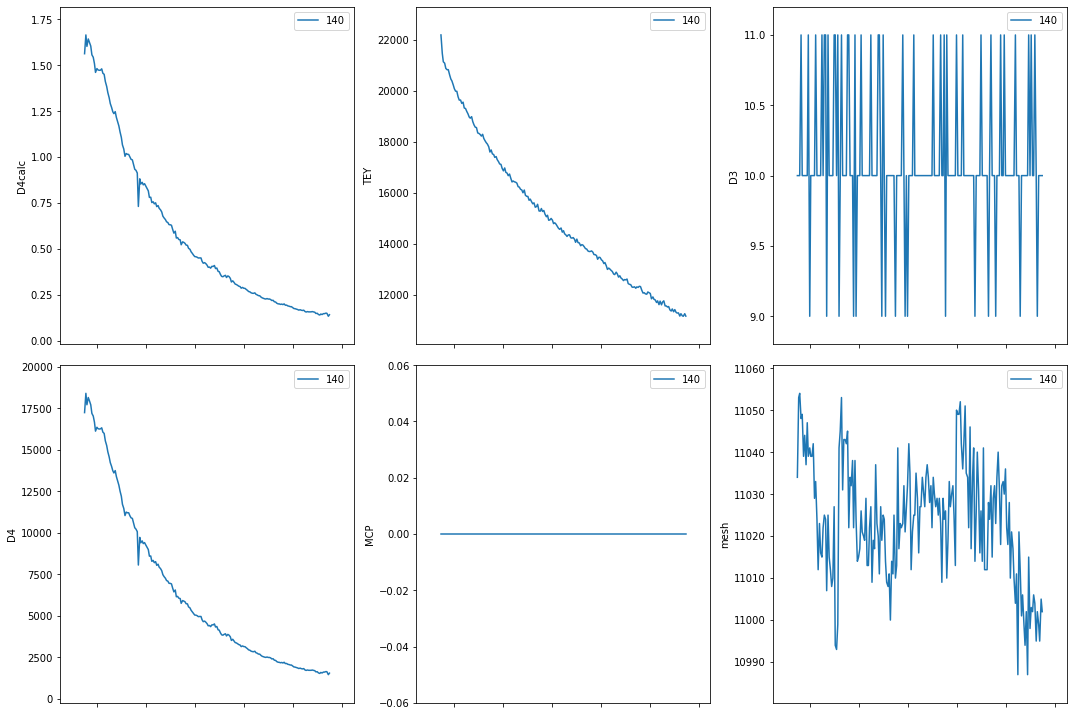

In [31]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(10,20,0.05,-2400,-5,komega)); slits.V4size.move(0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


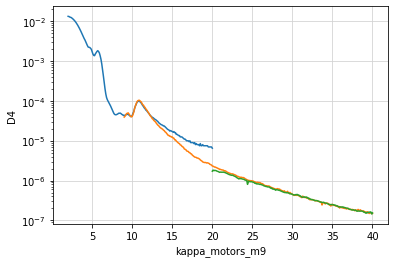

In [37]:
plot_reflectivity([137,139,140])

In [ ]:
playsound()

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


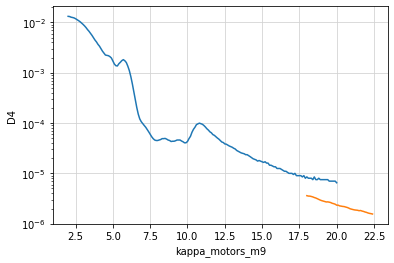

In [36]:
plot_reflectivity([137,138])

In [5]:
RE(energy_plan(695,0.5,True))

MEG 2 695
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.Deferred pause acknowledged. Continuing to checkpoint.

trying a second time
Pausing...


RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


In [6]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1479, in _run
    msg = self._plan_stack[-1].throw(
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 78, in plan_mutator
    msg = plan_stack[-1].throw(exception)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/py

()

In [7]:
d4_gain()

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


5.000000000000001e-07

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


Transient Scan ID: 141     Time: 2021-12-05 15:55:46
Persistent Unique Scan ID: 'db92fc66-0b2f-4d54-b781-8acd365ace6d'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0052589                    |
|              mono_mirror_pitch | 3.1440460205078127             |
|             mono_grating_pitch | 4.262280249023438              |
|                    centroidM3R | 110.35516993851627             |
|                kappa_motors_m2 | -3405.148                      |
|                kappa_motors_m3 | -0.019                         |
|                kappa_motors_m4 | 120.185                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.47714238179                 |
|                kappa_mot

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


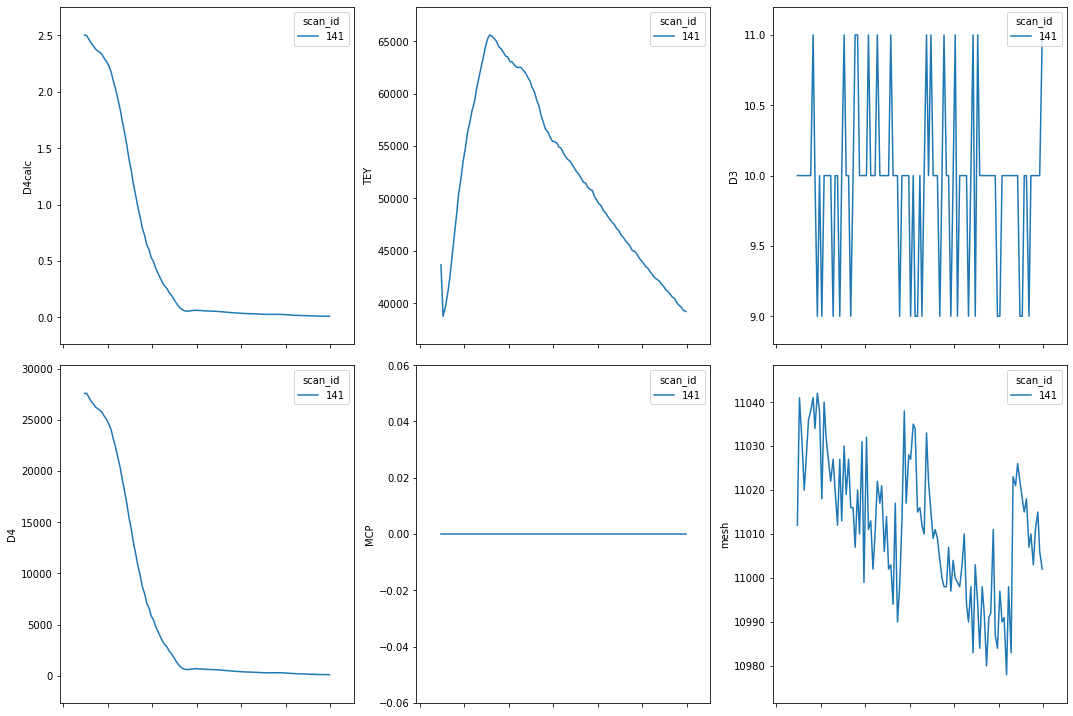

In [8]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,-3700,-5,komega)); slits.V4size.move(0)

In [9]:
RE.stop()

Stopping: running cleanup and marking exit_status as 'success'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['db92fc66'] (scan num: 141)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0058542                    |
|              mono_mirror_pitch | 3.14404296875                  |
|             mono_grating_pitch | 4.2622784179687505             |
|                    centroidM3R | 110.3082716204343              |
|                kappa_motors_m2 | -4253.144                      |
|                kappa_motors_m3 | -0.026000000000000002          |
|                kappa_motors_m4 | 120.19200000000001             |
|                kappa_motors_m9 | 13.0                           |
|                kappa_motors_m8 | 63.97714238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04507452                    |
|                select_detector | d4                             |
|         motors_H

('db92fc66-0b2f-4d54-b781-8acd365ace6d',)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


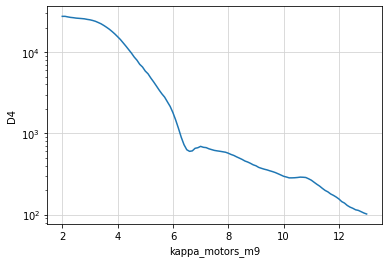

In [10]:
plot_latest(tth_motor,D4,log=True)

sensitivity: 2 nA/V
gain: 2e-09


Transient Scan ID: 142     Time: 2021-12-05 16:00:09
Persistent Unique Scan ID: '2944d138-8e5b-4ede-a20f-a5a4380a4d70'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6809664368629456             |
|                    mono_energy | 694.999892                     |
|              mono_mirror_pitch | 3.1440551757812503             |
|             mono_grating_pitch | 4.262306494140625              |
|                    centroidM3R | 110.39417855789873             |
|                kappa_motors_m2 | -4253.177                      |
|                kappa_motors_m3 | -0.023                         |
|                kappa_motors_m4 | 120.191                        |
|                kappa_motors_m9 | 11.0                           |
|                kappa_motors_m8 | 62.97714238179                 |
|                kappa_motors_m7 | 134.75600

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6814107298851013             |
|                    mono_energy | 694.9960936                    |
|              mono_mirror_pitch | 3.1440551757812503             |
|             mono_grating_pitch | 4.262271704101563              |
|                    centroidM3R | 110.44687252573239             |
|                kappa_motors_m2 | -5055.059                      |
|                kappa_motors_m3 | -0.03                          |
|                kappa_motors_m4 | 120.19500000000001             |
|                kappa_motors_m9 | 22.0                           |
|                kappa_motors_m8 | 68.47814238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.044972279999996             |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

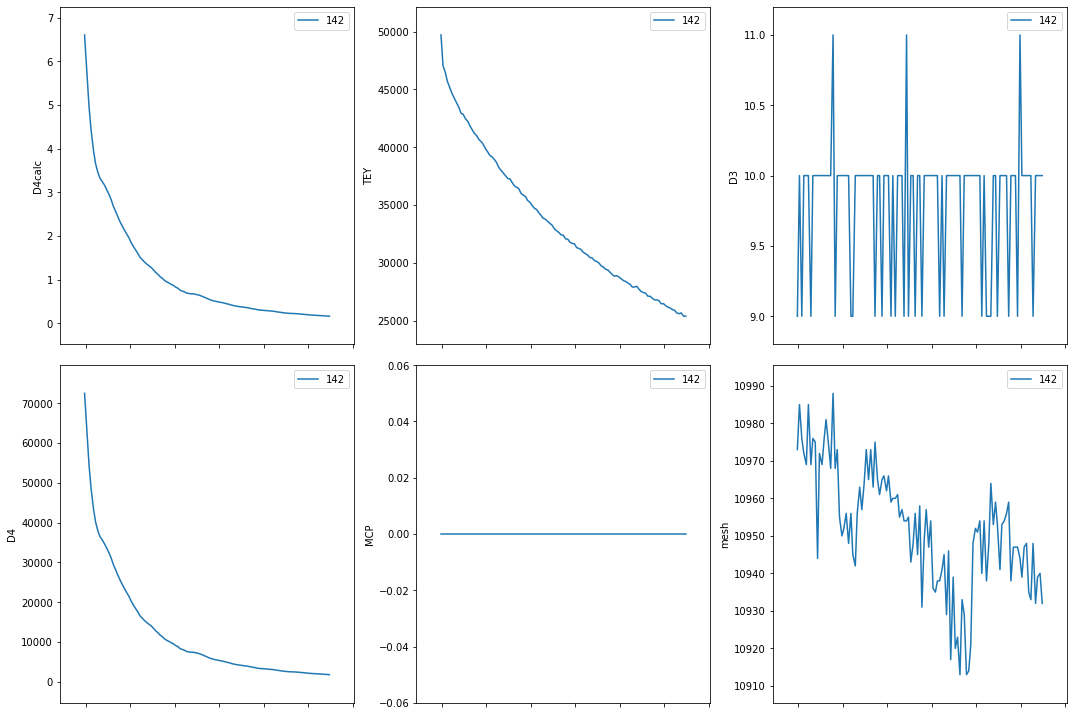

In [11]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(5.5,11,0.05,-4500,-5,komega)); slits.V4size.move(0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


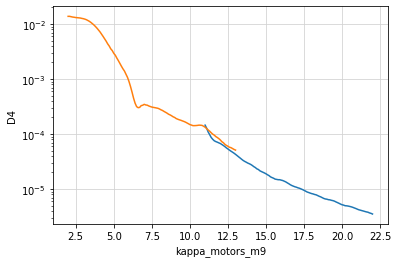

In [13]:
plot_reflectivity([-1,-2])

# New sample



Transient Scan ID: 143     Time: 2021-12-05 16:45:16
Persistent Unique Scan ID: 'f35e7a50-52f3-4eb3-b819-2cdef46be9c6'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0043329                    |
|              mono_mirror_pitch | 3.144039306640625              |
|             mono_grating_pitch | 4.262301611328125              |
|                    centroidM3R | 110.56536347935311             |
|                kappa_motors_m2 | -0.137                         |
|                kappa_motors_m3 | 0.047                          |
|                kappa_motors_m4 | 0.14400000000000002            |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.00014238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 694.9946007                    |
|              mono_mirror_pitch | 3.144093017578125              |
|             mono_grating_pitch | 4.262275366210938              |
|                    centroidM3R | 110.62012718600954             |
|                kappa_motors_m2 | -0.137                         |
|                kappa_motors_m3 | 0.049                          |
|                kappa_motors_m4 | 750.136                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.00014238179003              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.044614440000004             |
|                select_detector | d3                             |
|         motors_H

('f35e7a50-52f3-4eb3-b819-2cdef46be9c6',)

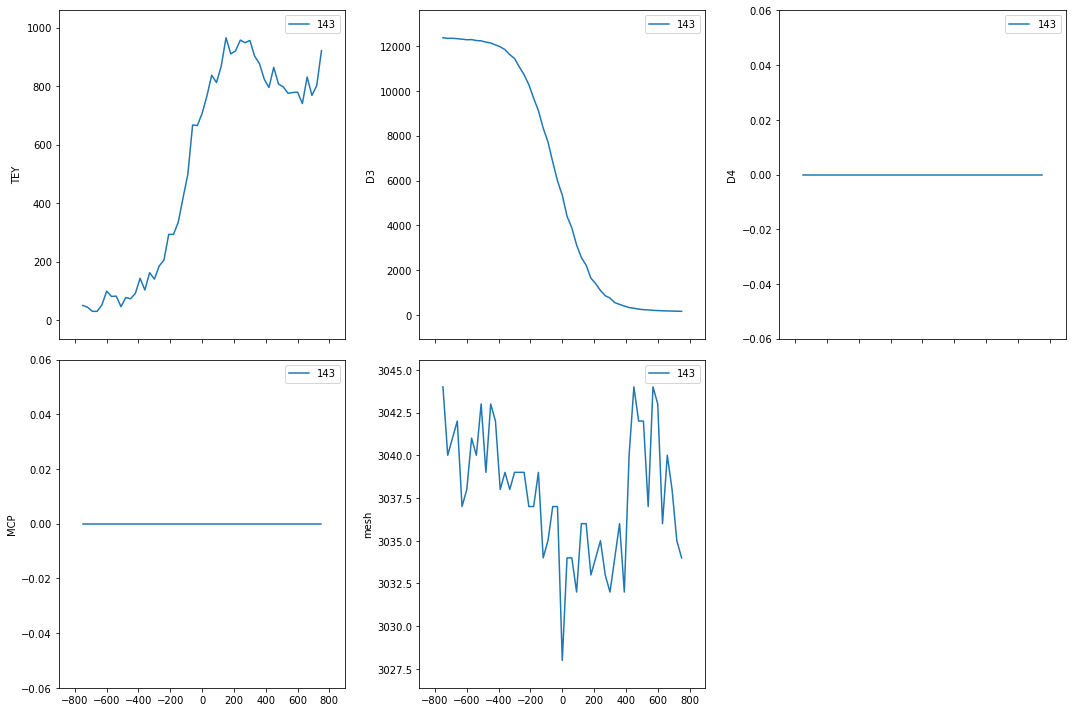

In [15]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))

In [16]:
find_z()

Array is :  [12363. 12335. 12340. 12321. 12300. 12275. 12281. 12238. 12225. 12167.
 12130. 12046. 11960. 11833. 11613. 11437. 11065. 10717. 10268.  9672.
  9116.  8340.  7722.  6831.  5987.  5351.  4410.  3891.  3131.  2568.
  2227.  1647.  1407.  1101.   870.   761.   560.   480.   408.   341.
   309.   269.   246.   233.   216.   206.   196.   190.   183.   177.
   171.]
Value to which nearest element is to be found:  6096.0
Nearest element to the given values is :  5987.0
Index of nearest value is :  24
Corresponding motor position of nearest value is :  -2.9855e+01


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


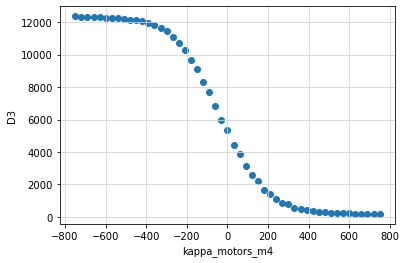

In [18]:
plot_scatter(-1,z_motor,D3)

In [19]:
RE(mvz(-30))

()

In [22]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 694.9847933                    |
|              mono_mirror_pitch | 3.1440155029296877             |
|             mono_grating_pitch | 4.262261938476563              |
|                    centroidM3R | 110.6880777661298              |
|                kappa_motors_m2 | -600.107                       |
|                kappa_motors_m3 | 0.009000000000000001           |
|                kappa_motors_m4 | -30.092000000000002            |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.09614238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.0451224                     |
|                selec

Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky

('11d95e35-95a7-4af2-bc95-22353c9336a2',)



Transient Scan ID: 145     Time: 2021-12-05 16:49:00
Persistent Unique Scan ID: '740e6508-f274-4515-ab99-362c0f2072cf'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6810774803161621             |
|                    mono_energy | 695.001092                     |
|              mono_mirror_pitch | 3.1440740966796876             |
|             mono_grating_pitch | 4.262277807617187              |
|                    centroidM3R | 110.70301966071932             |
|                kappa_motors_m2 | -600.111                       |
|                kappa_motors_m3 | 0.012                          |
|                kappa_motors_m4 | -30.092000000000002            |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.09614238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0008557                    |
|              mono_mirror_pitch | 3.1440533447265624             |
|             mono_grating_pitch | 4.262276586914062              |
|                    centroidM3R | 110.78693119193828             |
|                kappa_motors_m2 | -600.121                       |
|                kappa_motors_m3 | 0.009000000000000001           |
|                kappa_motors_m4 | -30.092000000000002            |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.59414238179002              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04513464                    |
|                select_detector | d4                             |
|         motors_H

('740e6508-f274-4515-ab99-362c0f2072cf',)

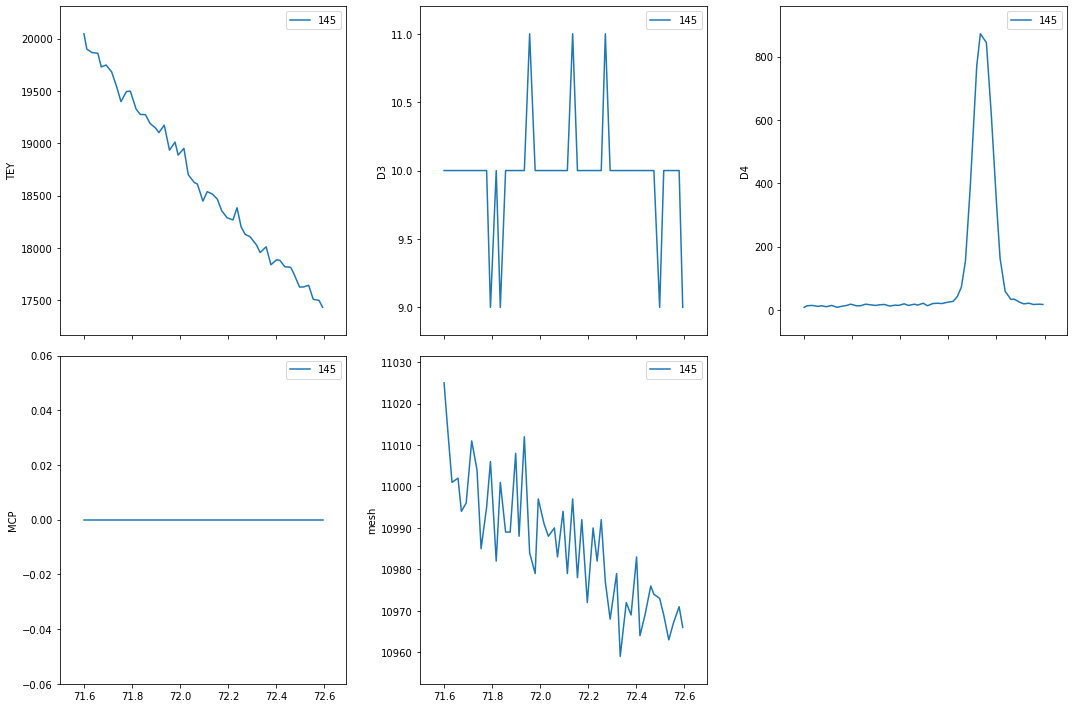

In [23]:
RE(bp.rel_scan([scaler],kth_motor,-0.5,0.5,51))

In [25]:
peaks

{
'com':
    {'D3': 72.09455495546389,
     'D4': 72.30981305486694,
     'MCP': nan,
     'TEY': 72.08148257269004,
     'mesh': 72.09476156003848}
,
'cen':
    {'D3': 72.12114238179002,
     'D4': 72.3435156837569,
     'MCP': None,
     'TEY': 72.03128523893288,
     'mesh': 71.9409594390797}
,
'max':
    {'D3': (71.95614238179002,
            11.0),
     'D4': (72.33314238179003,
            872.0),
     'MCP': (71.60014238179002,
             0.0),
     'TEY': (71.60014238179002,
             20047.0),
     'mesh': (71.60014238179002,
              11025.0)}
,
'min':
    {'D3': (71.79314238179,
            9.0),
     'D4': (71.60014238179002,
            8.0),
     'MCP': (71.60014238179002,
             0.0),
     'TEY': (72.59314238179002,
             17431.0),
     'mesh': (72.33314238179003,
              10959.0)}
,
'fwhm':
    {'D3': 0.3569999999999993,
     'D4': 0.09753717985000776,
     'MCP': None,
     'TEY': None,
     'mesh': 0.39252631578948183}
,
}

In [26]:
RE(mvkth(peaks['cen']['D4']))

()



Transient Scan ID: 147     Time: 2021-12-05 16:53:41
Persistent Unique Scan ID: '538f45f4-b853-4047-8b16-0b8749ea1b3f'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0019802                    |
|              mono_mirror_pitch | 3.1440856933593753             |
|             mono_grating_pitch | 4.26228330078125               |
|                    centroidM3R | 110.32957773149025             |
|                kappa_motors_m2 | -600.1370000000001             |
|                kappa_motors_m3 | 0.008                          |
|                kappa_motors_m4 | -30.096                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.34214238179001              |
|                kappa_motors_m7 | 134.76                         |
|       

('538f45f4-b853-4047-8b16-0b8749ea1b3f',)

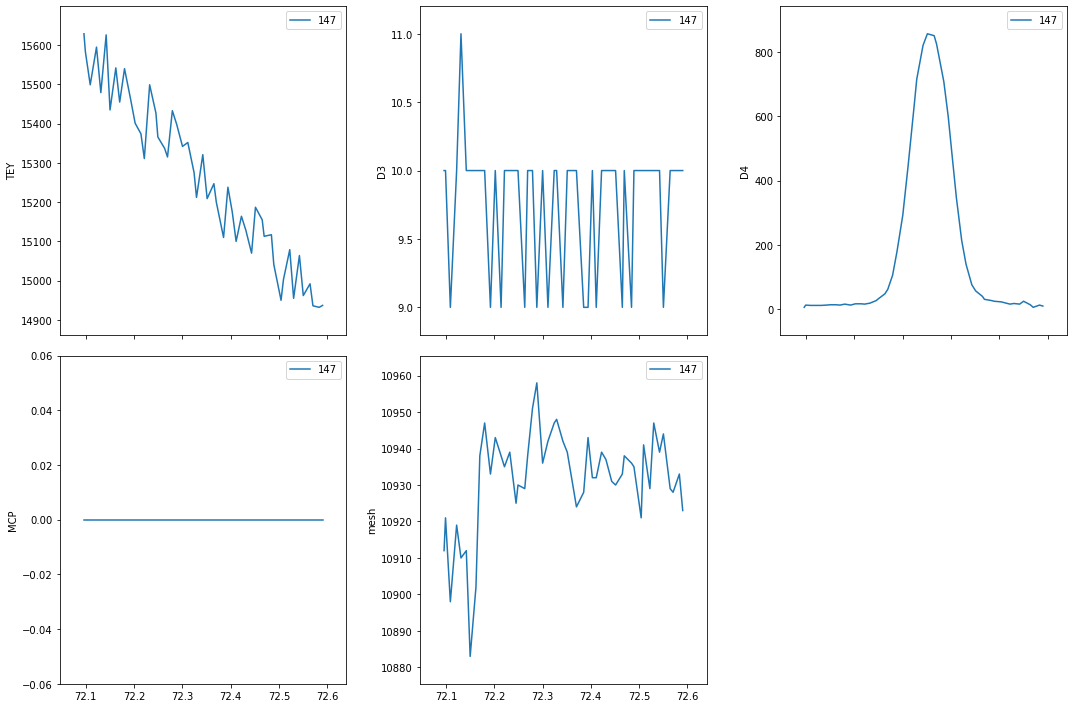

In [28]:
RE(bp.rel_scan([scaler],kth_motor,-0.25,0.25,51))

In [29]:
peaks

{
'com':
    {'D3': 72.3416986066896,
     'D4': 72.3594325717689,
     'MCP': nan,
     'TEY': 72.33968286544814,
     'mesh': 72.34220230484141}
,
'cen':
    {'D3': 72.13214238179002,
     'D4': 72.35781675153791,
     'MCP': None,
     'TEY': 72.33530758766595,
     'mesh': 72.12152966037294}
,
'max':
    {'D3': (72.13114238179003,
            11.0),
     'D4': (72.35114238179003,
            857.0),
     'MCP': (72.09614238179,
             0.0),
     'TEY': (72.09614238179,
             15629.0),
     'mesh': (72.28814238179001,
              10958.0)}
,
'min':
    {'D3': (72.10914238179001,
            9.0),
     'D4': (72.09614238179,
            6.0),
     'MCP': (72.09614238179,
             0.0),
     'TEY': (72.58314238179003,
             14932.0),
     'mesh': (72.15014238179,
              10883.0)}
,
'fwhm':
    {'D3': 0.020000000000010232,
     'D4': 0.09528991596640424,
     'MCP': None,
     'TEY': 0.022183035714292032,
     'mesh': 0.06727777777777533}
,
}

In [36]:
RE(mvkth(peaks['cen']['D4']))

()

In [33]:
komega=peaks['cen']['D4']-15

In [34]:
komega

57.35781675153791

In [35]:
komega-57.045

0.312816751537909

In [40]:
RE(uank(2,1+komega))

()

In [41]:
d4_gain()

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


5.000000000000001e-07

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


Transient Scan ID: 148     Time: 2021-12-05 17:00:11
Persistent Unique Scan ID: '0b588be2-edcf-4067-a05d-a7af944b7201'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 694.9980401                    |
|              mono_mirror_pitch | 3.1440875244140627             |
|             mono_grating_pitch | 4.262294897460937              |
|                    centroidM3R | 110.83532615500188             |
|                kappa_motors_m2 | -600.155                       |
|                kappa_motors_m3 | 0.017                          |
|                kappa_motors_m4 | -30.098                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.35814238179                 |
|                kappa_mot

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6810774803161621             |
|                    mono_energy | 694.9981156                    |
|              mono_mirror_pitch | 3.1440856933593753             |
|             mono_grating_pitch | 4.262271704101563              |
|                    centroidM3R | 110.95085692642742             |
|                kappa_motors_m2 | -1805.053                      |
|                kappa_motors_m3 | 0.002                          |
|                kappa_motors_m4 | -30.092000000000002            |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.35714238179003              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.0451638                     |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

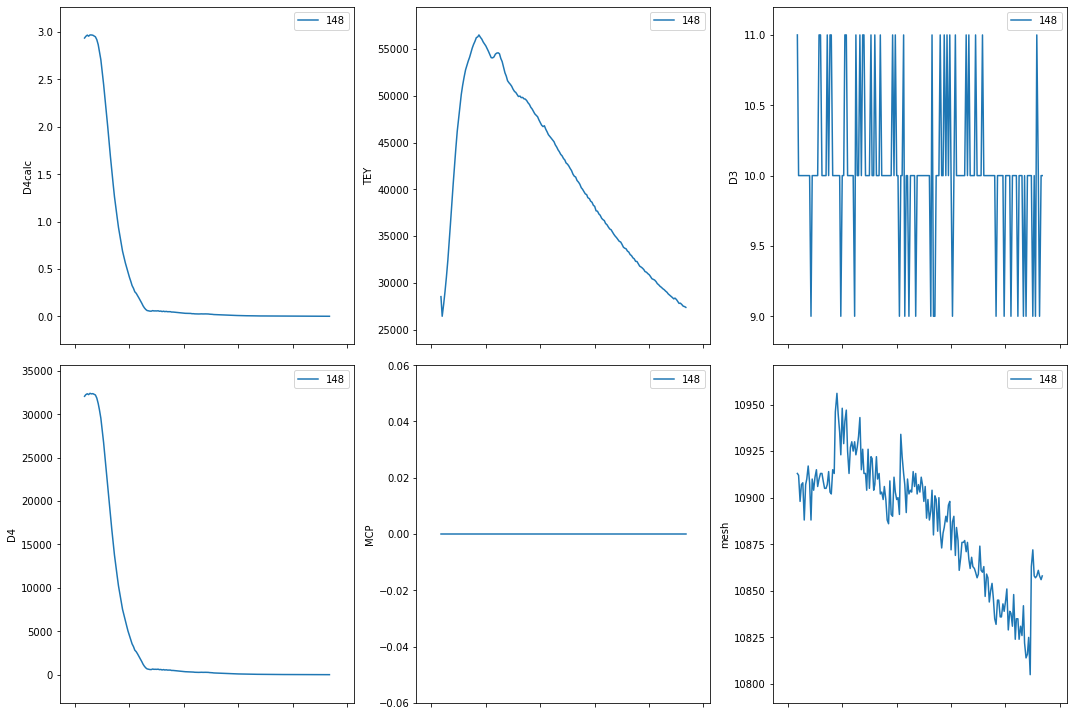

In [42]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,-900,-5,komega)); slits.V4size.move(0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


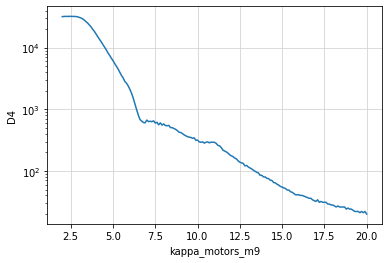

In [45]:
plot_latest(tth_motor,D4,log=True)

In [46]:
RE(uank(14,7.5+komega))

()

In [48]:
RE(slitBL_set(1))

()

sensitivity: 50 pA/V
gain: 5e-11


Transient Scan ID: 149     Time: 2021-12-05 17:07:57
Persistent Unique Scan ID: '8e6dff73-02b3-4150-ba4f-f94d6a939a2e'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6809664368629456             |
|                    mono_energy | 695.0051266                    |
|              mono_mirror_pitch | 3.1440325927734376             |
|             mono_grating_pitch | 4.26227109375                  |
|                    centroidM3R | 115.38093078234097             |
|                kappa_motors_m2 | -1805.113                      |
|                kappa_motors_m3 | 0.008                          |
|                kappa_motors_m4 | -30.092000000000002            |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.85814238179                 |
|                kappa_motors_m7 | 134.76  

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


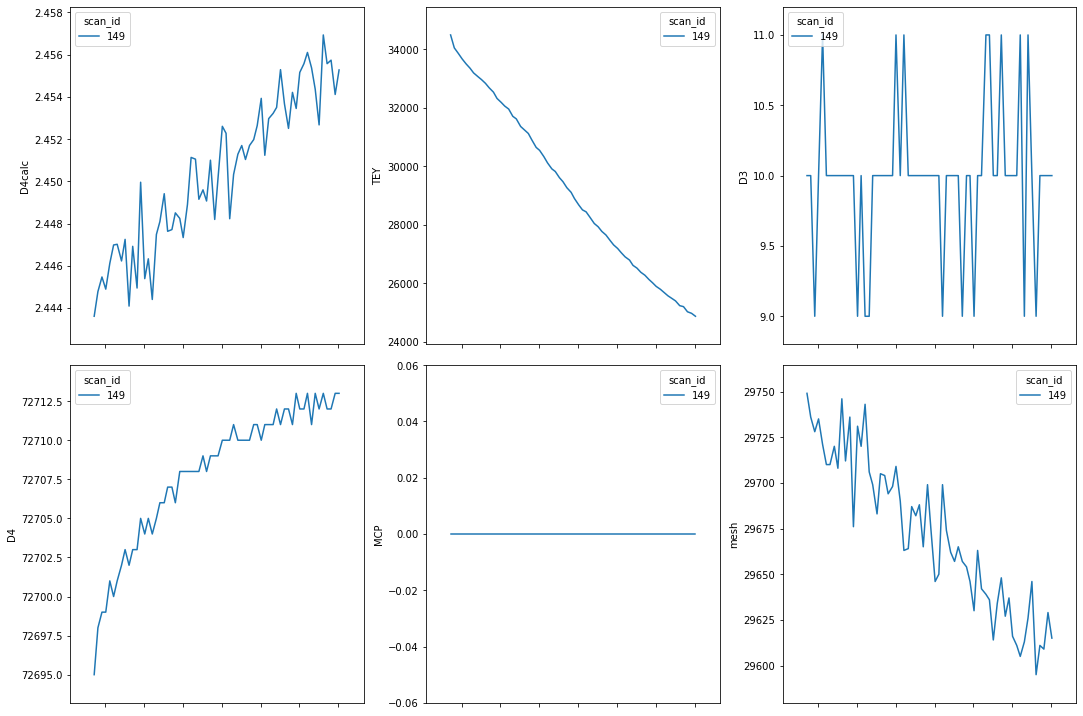

In [49]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(8,20,0.05,-2000,-5,komega)); slits.V4size.move(0)

In [50]:
RE.stop()

Stopping: running cleanup and marking exit_status as 'success'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['8e6dff73'] (scan num: 149)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6809664368629456             |
|                    mono_energy | 695.0045408                    |
|              mono_mirror_pitch | 3.144068603515625              |
|             mono_grating_pitch | 4.2622759765625                |
|                    centroidM3R | 115.44887599709935             |
|                kappa_motors_m2 | -2316.387                      |
|                kappa_motors_m3 | 0.001                          |
|                kappa_motors_m4 | -30.088                        |
|                kappa_motors_m9 | 22.3                           |
|                kappa_motors_m8 | 68.50814238179001              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04517532                    |
|                select_detector | d4                             |
|         motors_H

('8e6dff73-02b3-4150-ba4f-f94d6a939a2e',)

### M3R was off after opening B2

In [57]:
RE.abort('detector saturating')

Aborting: running cleanup and marking exit_status as 'abort'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['59637795'] (scan num: 151)
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 695.0004683                    |
|              mono_mirror_pitch | 3.1440643310546874             |
|             mono_grating_pitch | 4.262288793945313              |
|                    centroidM3R | 111.12613369163587             |
|                kappa_motors_m2 | -2741.081                      |
|                kappa_motors_m3 | -0.002                         |
|                kappa_motors_m4 | -30.084                        |
|                kappa_motors_m9 | 20.8                           |
|                kappa_

Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky

('59637795-05bd-4b70-bf42-0d8ef6f4b8da',)

In [59]:
RE(uank(14,7+komega))

()

sensitivity: 2 nA/V
gain: 2e-09


Transient Scan ID: 152     Time: 2021-12-05 17:15:30
Persistent Unique Scan ID: '1bd29576-a601-4ae9-aada-a0450459cbd6'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0010069                    |
|              mono_mirror_pitch | 3.1440655517578127             |
|             mono_grating_pitch | 4.262276586914062              |
|                    centroidM3R | 110.92062963271425             |
|                kappa_motors_m2 | -2741.103                      |
|                kappa_motors_m3 | 0.007                          |
|                kappa_motors_m4 | -30.09                         |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.35814238179                 |
|                kappa_motors_m7 | 134.76   

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

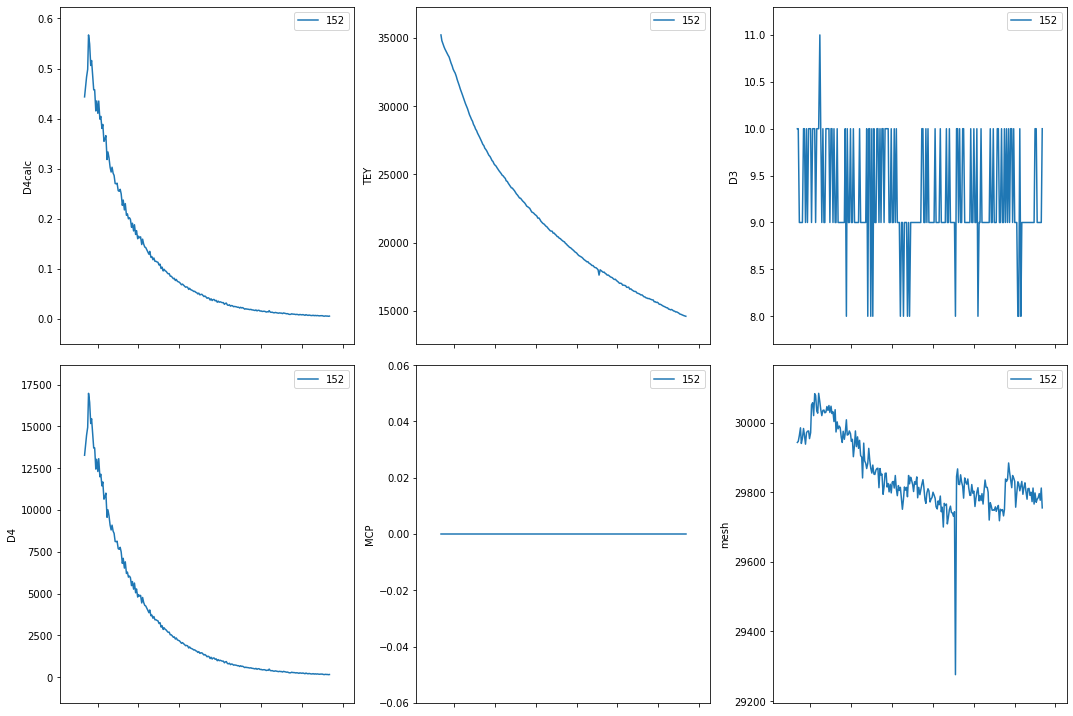

In [60]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(8,20,0.05,-3000,-5,komega)); slits.V4size.move(0)

In [ ]:
playsound()

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


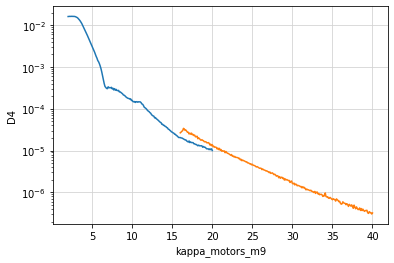

In [61]:
plot_reflectivity([148,-1])

In [62]:
a=0
RE(uank(a,a/2+komega))

()



Transient Scan ID: 153     Time: 2021-12-05 17:25:09
Persistent Unique Scan ID: 'f621960e-e0a2-4027-9f30-18ddaff6b211'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6812996864318848             |
|                    mono_energy | 695.0049093                    |
|              mono_mirror_pitch | 3.1440264892578127             |
|             mono_grating_pitch | 4.262299169921875              |
|                    centroidM3R | 111.13769789377035             |
|                kappa_motors_m2 | -4205.134                      |
|                kappa_motors_m3 | 0.007                          |
|                kappa_motors_m4 | -30.083000000000002            |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35714238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 694.9927961                    |
|              mono_mirror_pitch | 3.1440545654296876             |
|             mono_grating_pitch | 4.262316259765625              |
|                    centroidM3R | 111.11572497347998             |
|                kappa_motors_m2 | -4205.152                      |
|                kappa_motors_m3 | 0.026000000000000002           |
|                kappa_motors_m4 | 719.919                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04520124                    |
|                select_detector | d4                             |
|         motors_H

('f621960e-e0a2-4027-9f30-18ddaff6b211',)

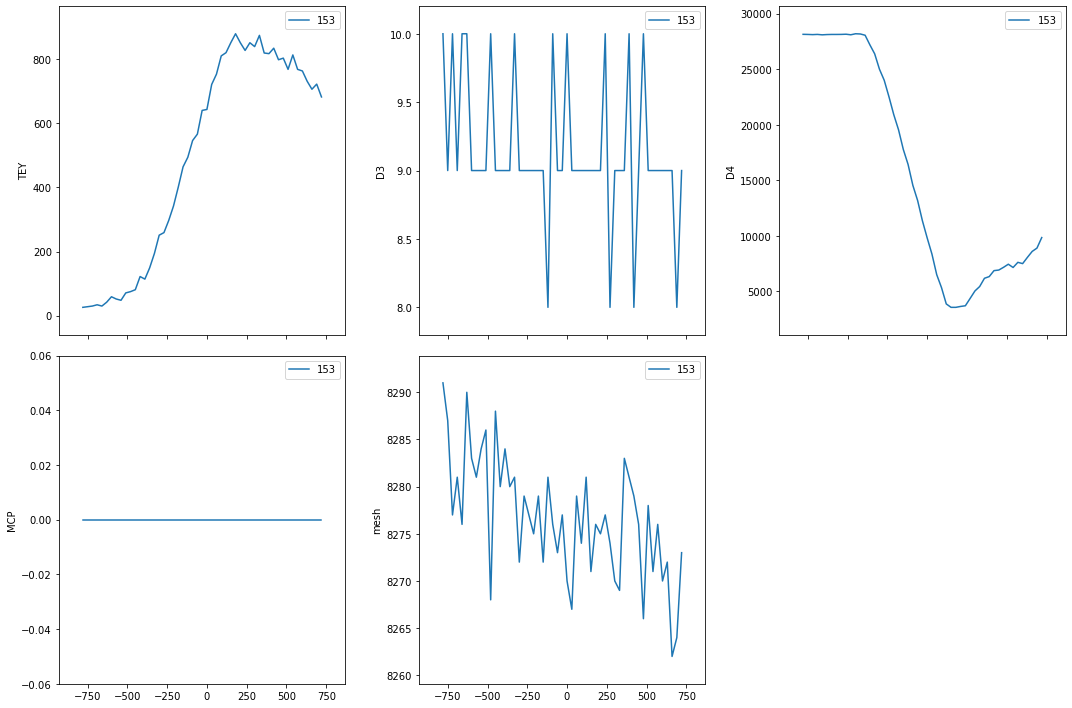

In [63]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


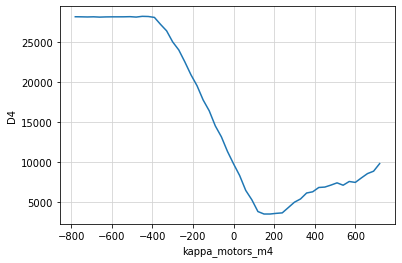

In [64]:
plot_latest(z_motor,D4)



Transient Scan ID: 154     Time: 2021-12-05 17:26:32
Persistent Unique Scan ID: '99bd612b-ace9-40c0-8a02-884749fd540f'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 695.0006384                    |
|              mono_mirror_pitch | 3.144061279296875              |
|             mono_grating_pitch | 4.262262548828125              |
|                    centroidM3R | 111.13829460395486             |
|                kappa_motors_m2 | -4205.135                      |
|                kappa_motors_m3 | -0.063                         |
|                kappa_motors_m4 | -30.326                        |
|                kappa_motors_m9 | 11.575                         |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.757                        |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6809664368629456             |
|                    mono_energy | 694.9895175                    |
|              mono_mirror_pitch | 3.14401123046875               |
|             mono_grating_pitch | 4.262296728515625              |
|                    centroidM3R | 111.0817207295002              |
|                kappa_motors_m2 | -4205.14                       |
|                kappa_motors_m3 | 0.009000000000000001           |
|                kappa_motors_m4 | 719.677                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.045195840000005             |
|                select_detector | d3                             |
|         motors_H

('99bd612b-ace9-40c0-8a02-884749fd540f',)

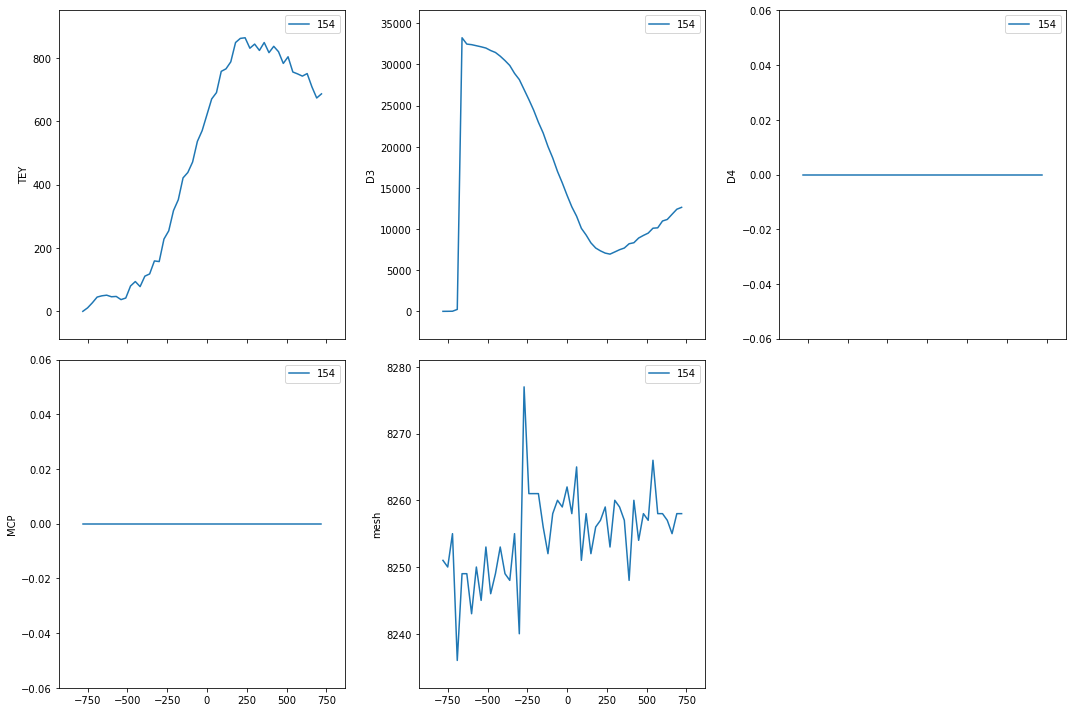

In [65]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))



Transient Scan ID: 155     Time: 2021-12-05 17:28:35
Persistent Unique Scan ID: 'e9f4de1f-8a9f-4c1c-b364-4ce398e9d3a6'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6811884641647339             |
|                    mono_energy | 694.9959897                    |
|              mono_mirror_pitch | 3.144041748046875              |
|             mono_grating_pitch | 4.262274145507813              |
|                    centroidM3R | 111.19704234944197             |
|                kappa_motors_m2 | -0.012                         |
|                kappa_motors_m3 | 0.008                          |
|                kappa_motors_m4 | -30.533                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

('e9f4de1f-8a9f-4c1c-b364-4ce398e9d3a6',)

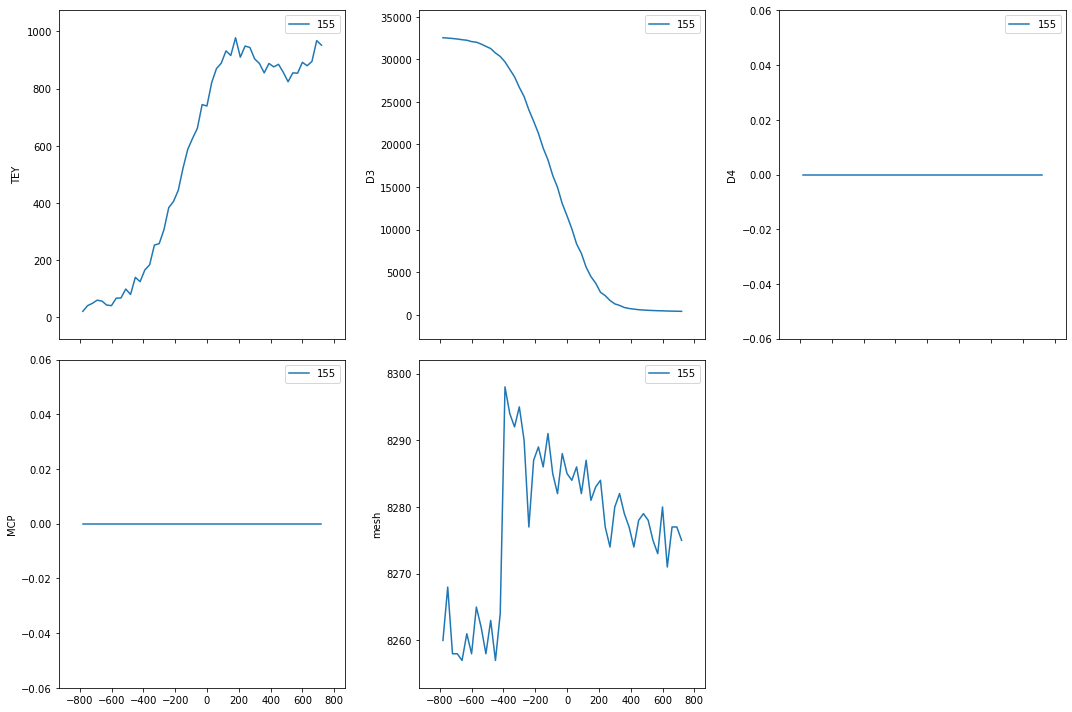

In [66]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))

In [67]:
find_z()

Array is :  [32538. 32502. 32451. 32394. 32309. 32247. 32089. 32016. 31803. 31528.
 31270. 30746. 30342. 29704. 28826. 27949. 26715. 25631. 24066. 22734.
 21316. 19581. 18198. 16367. 14969. 13041. 11612. 10102.  8320.  7209.
  5591.  4482.  3712.  2644.  2245.  1677.  1281.  1099.   853.   738.
   664.   594.   558.   522.   498.   476.   459.   442.   428.   414.
   402.]
Value to which nearest element is to be found:  16068.0
Nearest element to the given values is :  16367.0
Index of nearest value is :  23
Corresponding motor position of nearest value is :  -90.528


In [73]:
RE(mvz(-90))

()

In [70]:
RE(energy_plan(691,m3r=True))

MEG 2 691


()



Transient Scan ID: 156     Time: 2021-12-05 17:33:54
Persistent Unique Scan ID: '05c396d8-1cd4-4d42-b897-d8db9ea7415c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6699906587600708             |
|                    mono_energy | 691.0042655                    |
|              mono_mirror_pitch | 3.15315673828125               |
|             mono_grating_pitch | 4.274615454101562              |
|                    centroidM3R | 110.87127975217953             |
|                kappa_motors_m2 | -0.01                          |
|                kappa_motors_m3 | 0.004                          |
|                kappa_motors_m4 | -89.909                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35714238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6697736978530884             |
|                    mono_energy | 690.9956631                    |
|              mono_mirror_pitch | 3.1531689453125002             |
|             mono_grating_pitch | 4.274615454101562              |
|                    centroidM3R | 110.82815112876254             |
|                kappa_motors_m2 | -0.008                         |
|                kappa_motors_m3 | 0.009000000000000001           |
|                kappa_motors_m4 | 660.094                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35714238179003              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.045180720000005             |
|                select_detector | d3                             |
|         motors_H

('05c396d8-1cd4-4d42-b897-d8db9ea7415c',)

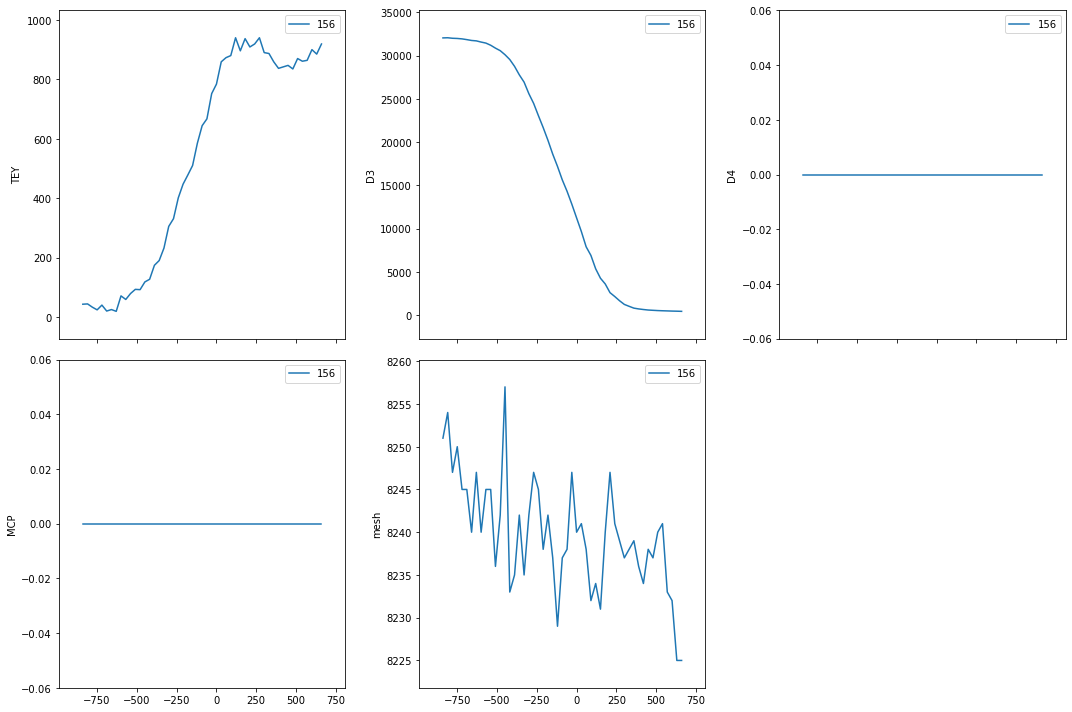

In [74]:
RE(bp.rel_scan([scaler],z_motor,-750,750,51))

In [75]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [76]:
find_z()

Array is :  [32058. 32075. 32016. 31994. 31945. 31859. 31762. 31714. 31576. 31458.
 31209. 30874. 30580. 30113. 29557. 28766. 27783. 26939. 25602. 24480.
 23060. 21682. 20209. 18608. 17186. 15634. 14310. 12820. 11230.  9648.
  7886.  6887.  5335.  4247.  3585.  2578.  2128.  1642.  1218.   998.
   787.   696.   627.   568.   536.   505.   483.   465.   446.   433.
   416.]
Value to which nearest element is to be found:  15829.5
Nearest element to the given values is :  15634.0
Index of nearest value is :  25
Corresponding motor position of nearest value is :  -89.91


In [79]:
a=2
RE(uank(a,a/2+komega))

()

sensitivity: 100 nA/V
gain: 1.0000000000000001e-07


Transient Scan ID: 157     Time: 2021-12-05 17:36:57
Persistent Unique Scan ID: '3840294c-89f3-41b7-825d-94e11f249345'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6700991988182068             |
|                    mono_energy | 690.9927396                    |
|              mono_mirror_pitch | 3.1531768798828126             |
|             mono_grating_pitch | 4.274611181640625              |
|                    centroidM3R | 111.05472338985697             |
|                kappa_motors_m2 | 0.001                          |
|                kappa_motors_m3 | 0.001                          |
|                kappa_motors_m4 | -90.179                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.35814238179                 |
|                kappa_mo

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6699906587600708             |
|                    mono_energy | 691.0002117                    |
|              mono_mirror_pitch | 3.1531280517578124             |
|             mono_grating_pitch | 4.274610571289062              |
|                    centroidM3R | 110.99438540466967             |
|                kappa_motors_m2 | 1205.025                       |
|                kappa_motors_m3 | 0.001                          |
|                kappa_motors_m4 | -90.186                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.045177839999994             |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

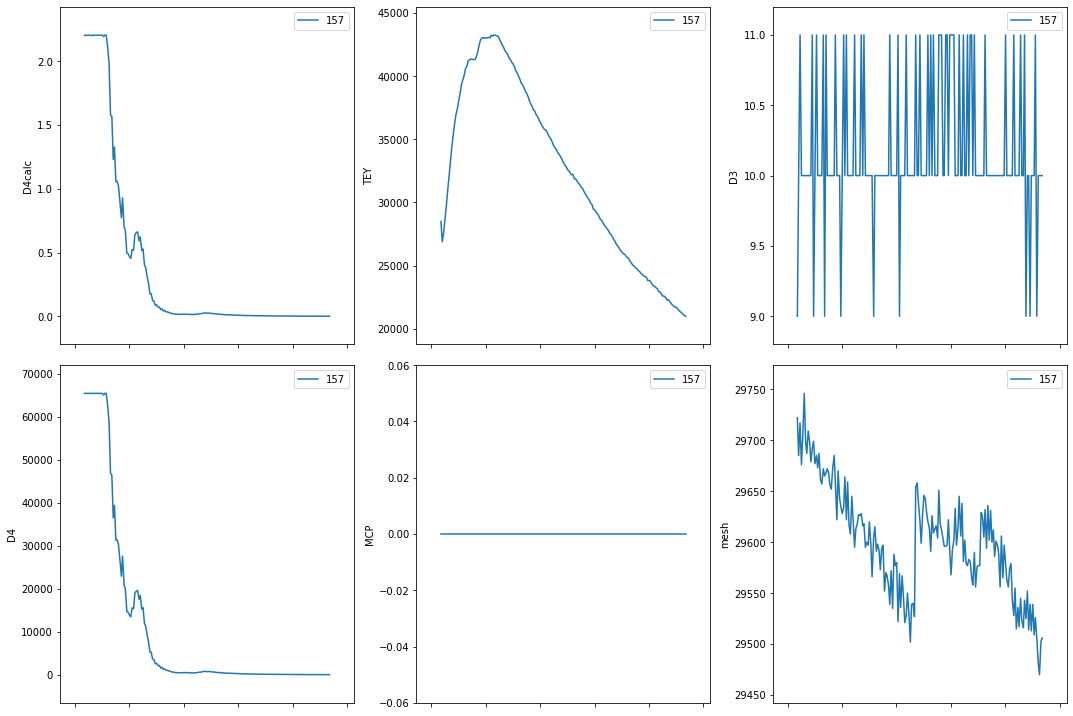

In [80]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,300,5,komega)); slits.V4size.move(0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


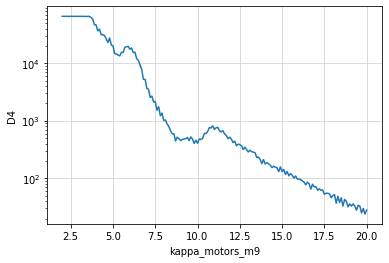

In [83]:
plot_latest(tth_motor,D4,log=True)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


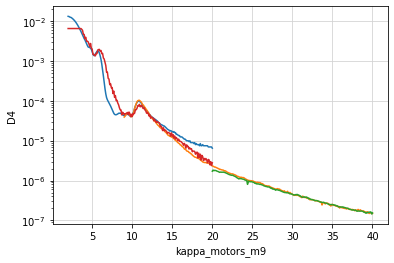

In [84]:
plot_reflectivity([137,139,140,157])

In [85]:
a=15
RE(uank(a,a/2+komega))

()

In [86]:
komega-57.045

0.312816751537909

sensitivity: 200 pA/V
gain: 2e-10


Transient Scan ID: 158     Time: 2021-12-05 17:44:38
Persistent Unique Scan ID: 'eb8d78fc-a53c-42c3-8f74-bada6ab1a8d1'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6698822975158691             |
|                    mono_energy | 690.9868274                    |
|              mono_mirror_pitch | 3.153193359375                 |
|             mono_grating_pitch | 4.274626440429688              |
|                    centroidM3R | 111.21602407422009             |
|                kappa_motors_m2 | 1205.057                       |
|                kappa_motors_m3 | 0.008                          |
|                kappa_motors_m4 | -90.19                         |
|                kappa_motors_m9 | 15.0                           |
|                kappa_motors_m8 | 64.85814238179                 |
|                kappa_motors_m7 | 134.76 

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6699906587600708             |
|                    mono_energy | 690.9803829                    |
|              mono_mirror_pitch | 3.1532019042968753             |
|             mono_grating_pitch | 4.274634375                    |
|                    centroidM3R | 111.47558299940879             |
|                kappa_motors_m2 | 2705.035                       |
|                kappa_motors_m3 | -0.003                         |
|                kappa_motors_m4 | -90.181                        |
|                kappa_motors_m9 | 40.0                           |
|                kappa_motors_m8 | 77.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04518                       |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

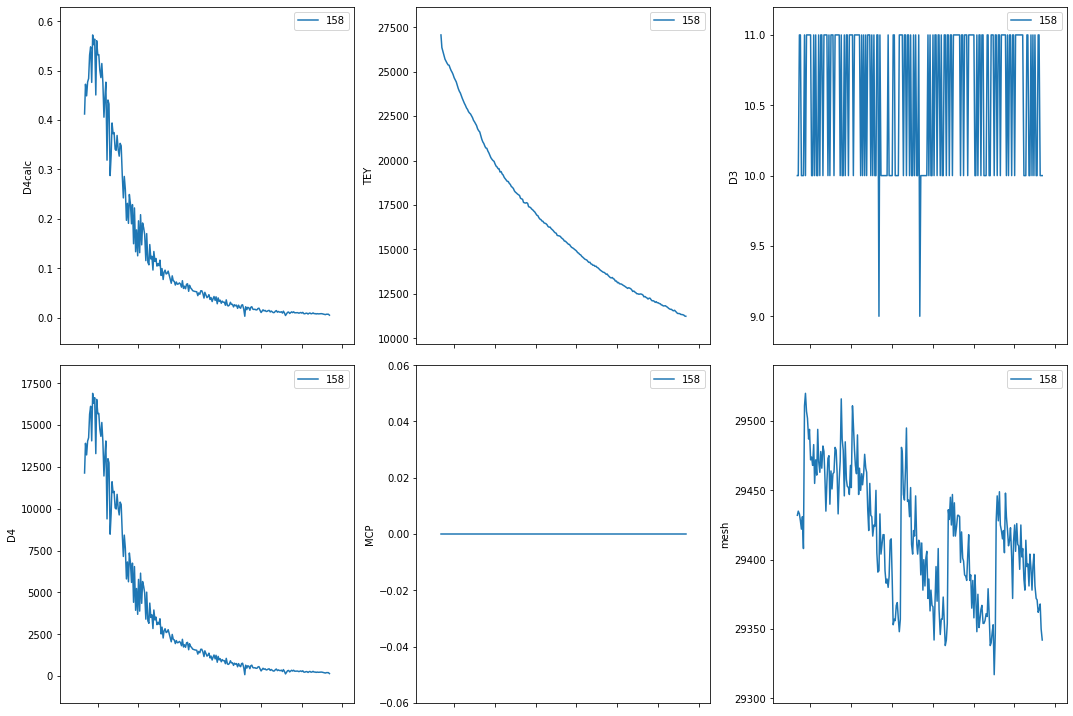

In [87]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(8,20,0.05,1500,5,komega)); slits.V4size.move(0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


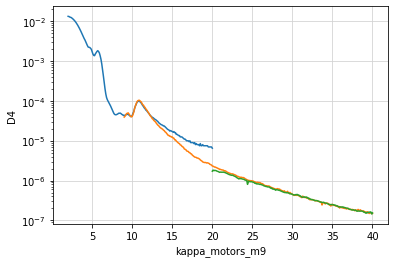

In [91]:
plot_reflectivity([137,139,140])  # previous sample

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


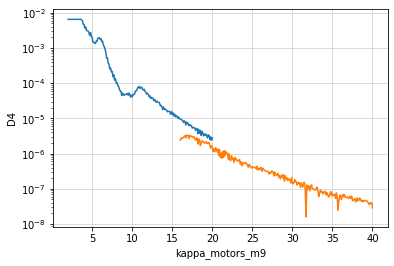

In [88]:
plot_reflectivity([157,158])  # current sample

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


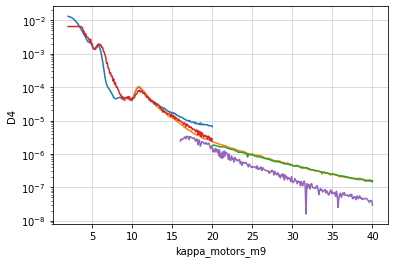

In [89]:
plot_reflectivity([137,139,140,157,158])

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


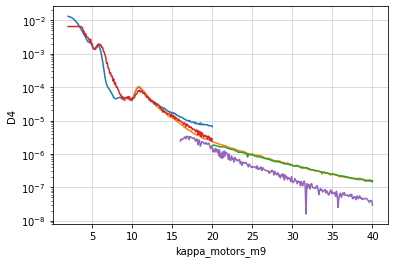

In [89]:
plot_reflectivity([137,139,140,157,158])

In [90]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


# POEM



Transient Scan ID: 160     Time: 2021-12-05 18:10:06
Persistent Unique Scan ID: 'a899369c-6826-4b3b-a116-79f4e59c61e3'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6700991988182068             |
|                    mono_energy | 691.0018183                    |
|              mono_mirror_pitch | 3.153148193359375              |
|             mono_grating_pitch | 4.2746380371093755             |
|                    centroidM3R | 111.42769736842105             |
|                kappa_motors_m2 | 11.752                         |
|                kappa_motors_m3 | 0.058                          |
|                kappa_motors_m4 | -0.187                         |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75900000000001             |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6697736978530884             |
|                    mono_energy | 691.008889                     |
|              mono_mirror_pitch | 3.1531744384765625             |
|             mono_grating_pitch | 4.2746160644531255             |
|                    centroidM3R | 111.34532308135651             |
|                kappa_motors_m2 | 11.752                         |
|                kappa_motors_m3 | 0.062                          |
|                kappa_motors_m4 | 749.809                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75900000000001             |
|                kappa_motors_m1 | 57.04374072                    |
|                select_detector | d3                             |
|         motors_H

('a899369c-6826-4b3b-a116-79f4e59c61e3',)

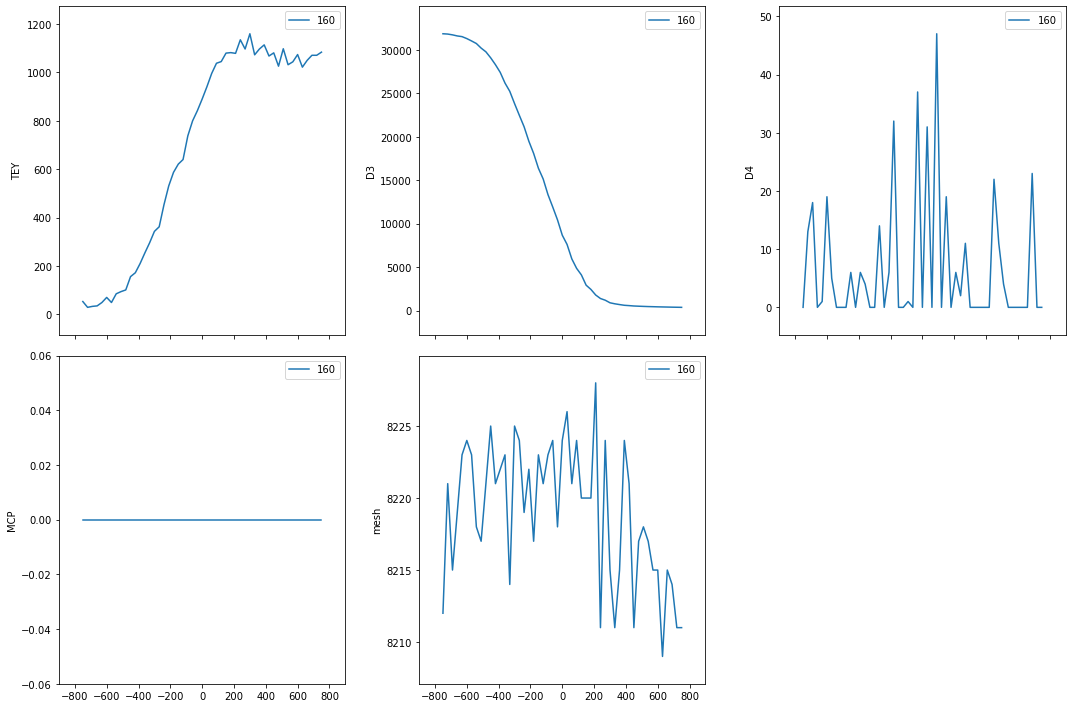

In [96]:
RE(align_z())

In [97]:
find_z()

Array is :  [31851. 31816. 31725. 31600. 31520. 31296. 31021. 30728. 30201. 29772.
 29083. 28291. 27406. 26178. 25227. 23819. 22471. 21150. 19481. 18081.
 16375. 15137. 13345. 11914. 10431.  8669.  7609.  5940.  4855.  4102.
  2915.  2429.  1786.  1381.  1187.   889.   774.   685.   603.   565.
   521.   497.   475.   455.   441.   424.   411.   399.   386.   376.
   366.]
Value to which nearest element is to be found:  15742.5
Nearest element to the given values is :  15137.0
Index of nearest value is :  21
Corresponding motor position of nearest value is :  -120.19800000000001


In [98]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo




Transient Scan ID: 161     Time: 2021-12-05 18:14:06
Persistent Unique Scan ID: 'b08ac080-8d41-489c-b560-114f100d9e49'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6699906587600708             |
|                    mono_energy | 690.9900684                    |
|              mono_mirror_pitch | 3.1531579589843752             |
|             mono_grating_pitch | 4.274641088867187              |
|                    centroidM3R | 111.28889823933939             |
|                kappa_motors_m2 | 11.761000000000001             |
|                kappa_motors_m3 | 0.025                          |
|                kappa_motors_m4 | -120.259                       |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.05114238179002              |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6698822975158691             |
|                    mono_energy | 691.0027617                    |
|              mono_mirror_pitch | 3.1531396484375                |
|             mono_grating_pitch | 4.274597143554687              |
|                    centroidM3R | 111.3298122372235              |
|                kappa_motors_m2 | 11.763                         |
|                kappa_motors_m3 | 0.027                          |
|                kappa_motors_m4 | -120.26                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.55114238179002              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04506012                    |
|                select_detector | d4                             |
|         motors_H

('b08ac080-8d41-489c-b560-114f100d9e49',)

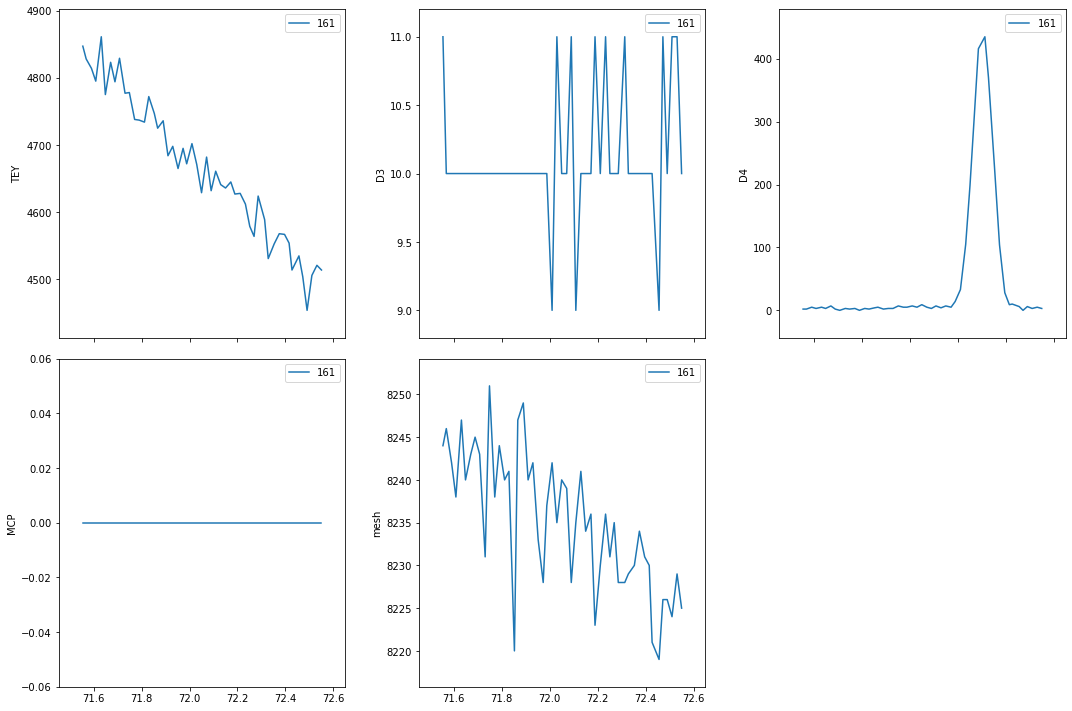

In [100]:
RE(align_kth())

In [103]:
peaks

{
'com':
    {'D3': 72.05225866085978,
     'D4': 72.27987662722948,
     'MCP': nan,
     'TEY': 72.04365652450728,
     'mesh': 72.04993314070562}
,
'cen':
    {'D3': 72.21764238179001,
     'D4': 72.30453149469324,
     'MCP': None,
     'TEY': 72.0796249659521,
     'mesh': 72.0188992678669}
,
'max':
    {'D3': (71.55514238179,
            11.0),
     'D4': (72.31314238179002,
            435.0),
     'MCP': (71.55514238179,
             0.0),
     'TEY': (71.63214238179,
             4861.0),
     'mesh': (71.74914238179002,
              8251.0)}
,
'min':
    {'D3': (72.01014238179002,
            9.0),
     'D4': (71.70814238179003,
            0.0),
     'MCP': (71.55514238179,
             0.0),
     'TEY': (72.49014238179001,
             4454.0),
     'mesh': (72.45614238179002,
              8219.0)}
,
'fwhm':
    {'D3': 0.9809999999999945,
     'D4': 0.1007782258064509,
     'MCP': None,
     'TEY': 0.07624642857140884,
     'mesh': 0.5132666666666523}
,
}

In [104]:
RE(mvkth(peaks['cen']['D4']))

()



Transient Scan ID: 162     Time: 2021-12-05 18:19:56
Persistent Unique Scan ID: '29ee82ef-4575-4036-84fe-df8a7a6155a2'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6699906587600708             |
|                    mono_energy | 690.9932907                    |
|              mono_mirror_pitch | 3.1531011962890627             |
|             mono_grating_pitch | 4.274626440429688              |
|                    centroidM3R | 111.3692874724874              |
|                kappa_motors_m2 | 11.765                         |
|                kappa_motors_m3 | 0.024                          |
|                kappa_motors_m4 | -120.26                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.30414238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


{
'com':
    {'D3': 72.30301665645153,
     'D4': 72.29693778117013,
     'MCP': nan,
     'TEY': 72.30116717189668,
     'mesh': 72.30305272083862}
,
'cen':
    {'D3': 72.25307095321861,
     'D4': 72.30190125169986,
     'MCP': None,
     'TEY': 72.34636815986212,
     'mesh': 72.41833295912792}
,
'max':
    {'D3': (72.05814238179002,
            11.0),
     'D4': (72.30314238179002,
            5183.0),
     'MCP': (72.05814238179002,
             0.0),
     'TEY': (72.10414238179001,
             4608.0),
     'mesh': (72.11214238179002,
              8227.0)}
,
'min':
    {'D3': (72.06114238179,
            9.0),
     'D4': (72.52614238179001,
            12.0),
     'MCP': (72.05814238179002,
             0.0),
     'TEY': (72.53114238179,
             4366.0),
     'mesh': (72.53114238179,
              8194.0)}
,
'fwhm':
    {'D3': 0.39850000000001273,
     'D4': 0.09802251688977037,
     'MCP': None,
     'TEY': 0.12830306905371458,
     'mesh': 0.31750657894735923}
,
}

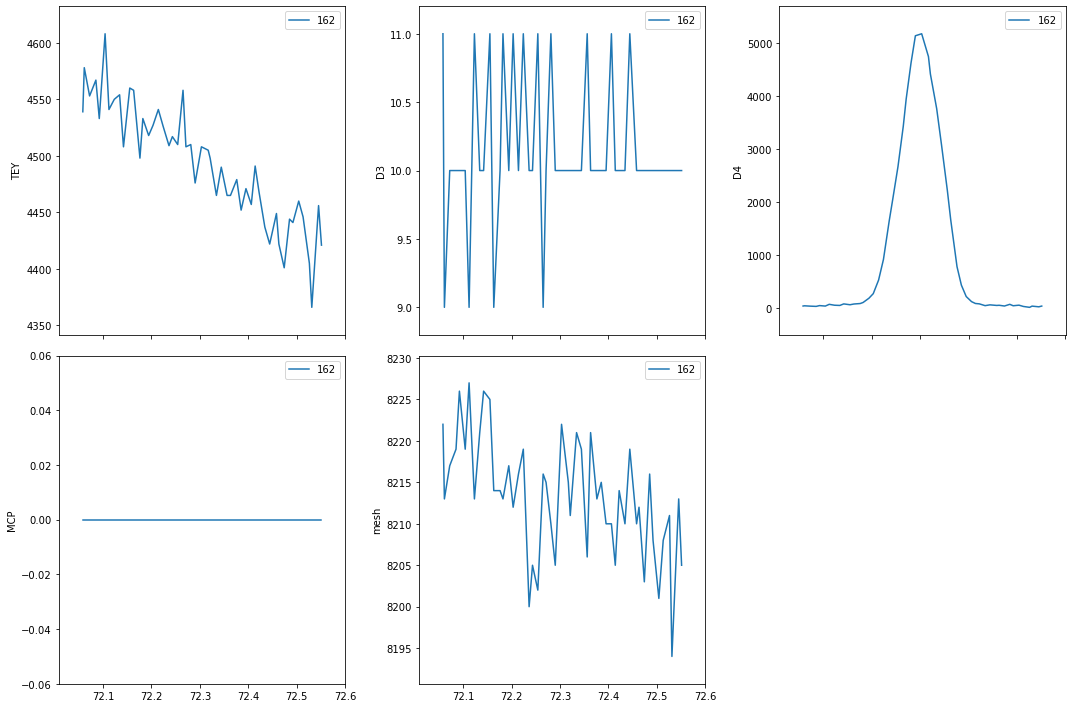

In [107]:
RE(align_kth()); playsound(); peaks

In [108]:
RE(mvkth(peaks['cen']['D4']))

()

In [113]:
peaks['cen']['D4']

72.30190125169986

In [110]:
komega=peaks['cen']['D4']-15

In [111]:
komega

57.30190125169986

In [112]:
komega-57.045

0.25690125169985834

In [116]:
a=2
RE(uank(a,a/2+komega))

()

sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


Transient Scan ID: 163     Time: 2021-12-05 18:26:35
Persistent Unique Scan ID: '8a0eb263-55bc-4eb2-b729-ab12ffbd5e92'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6697736978530884             |
|                    mono_energy | 690.9943928                    |
|              mono_mirror_pitch | 3.153206787109375              |
|             mono_grating_pitch | 4.2746117919921875             |
|                    centroidM3R | 111.56098868763486             |
|                kappa_motors_m2 | 11.781                         |
|                kappa_motors_m3 | 0.031                          |
|                kappa_motors_m4 | -120.267                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.35814238179                 |
|                kappa_mo

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


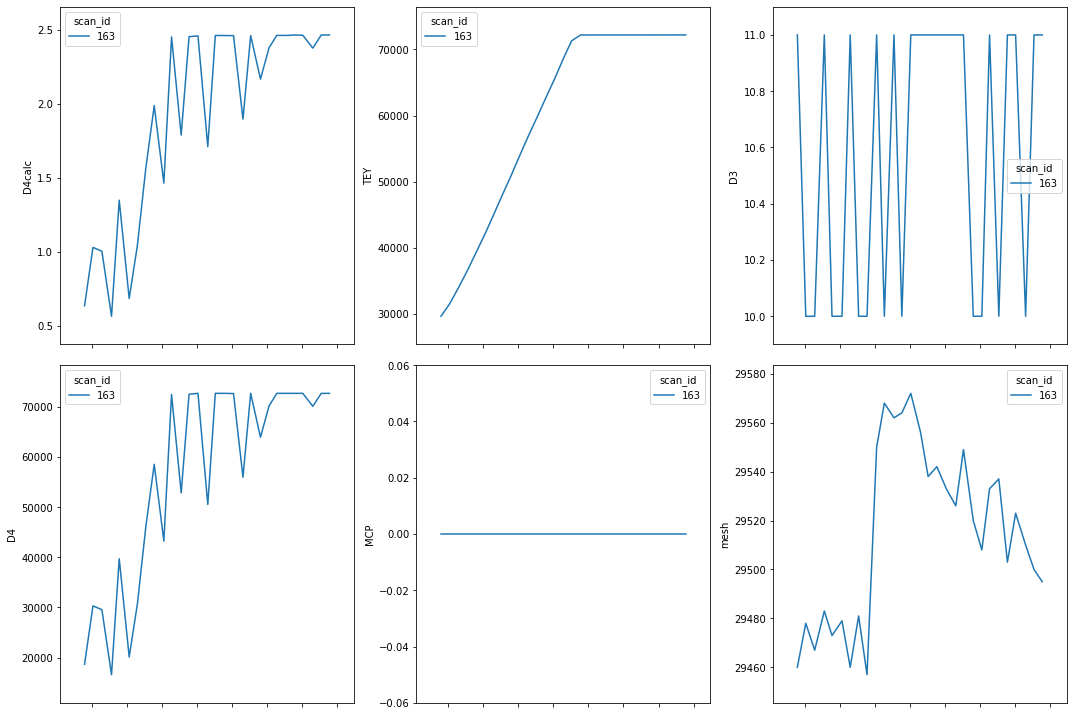

In [117]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,300,5,komega)); slits.V4size.move(0)

In [118]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['8a0eb263'] (scan num: 163)
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6696652770042419             |
|                    mono_energy | 691.0116724                    |
|              mono_mirror_pitch | 3.1531329345703125             |
|             mono_grating_pitch | 4.274603247070313              |
|                    centroidM3R | 111.56620980702144             |
|                kappa_motors_m2 | 440.86                         |
|                kappa_motors_m3 | 0.027                          |
|                kappa_motors_m4 | -120.268                       |
|                kappa_motors_m9 | 4.8                            |
|                kappa_

Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky

('8a0eb263-55bc-4eb2-b729-ab12ffbd5e92',)

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


Transient Scan ID: 165     Time: 2021-12-05 18:29:32
Persistent Unique Scan ID: '57129f9d-c50a-4358-be6a-671e90b1d55c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6698822975158691             |
|                    mono_energy | 690.9885927                    |
|              mono_mirror_pitch | 3.1531396484375                |
|             mono_grating_pitch | 4.274618505859375              |
|                    centroidM3R | 111.65128385783623             |
|                kappa_motors_m2 | 330.265                        |
|                kappa_motors_m3 | 0.029                          |
|                kappa_motors_m4 | -120.269                       |
|                kappa_motors_m9 | 2.6                            |
|                kappa_motors_m8 | 58.658142381790014             |
|                kappa_mot

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

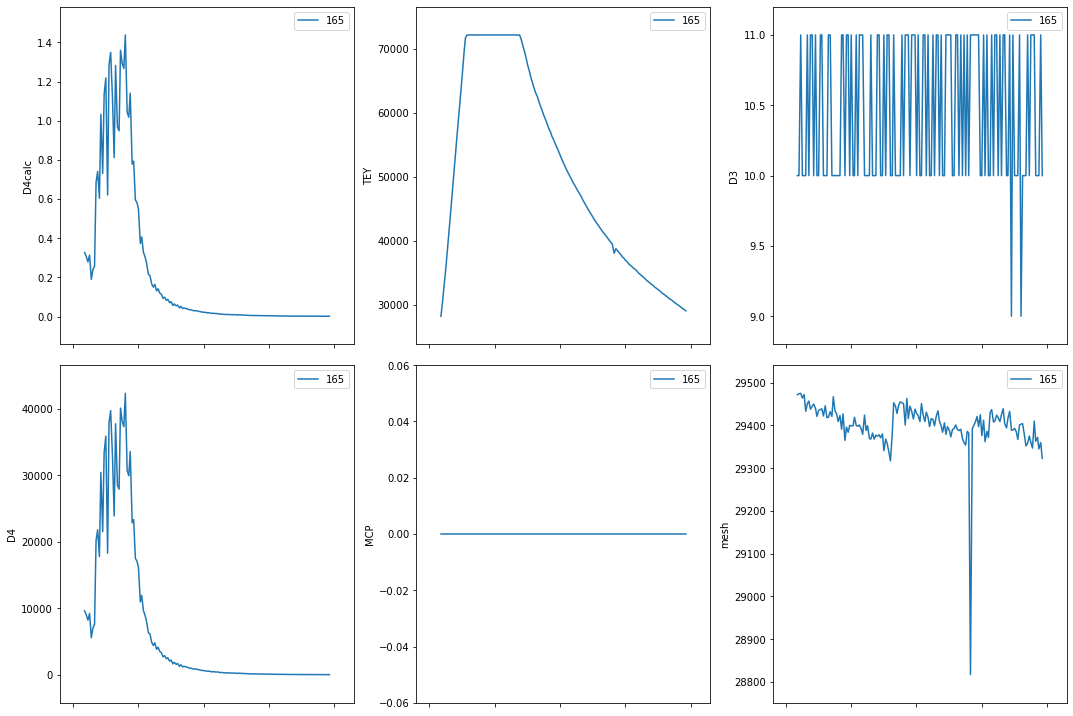

In [121]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,8.5,0.05,500,5,komega)); slits.V4size.move(0)

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


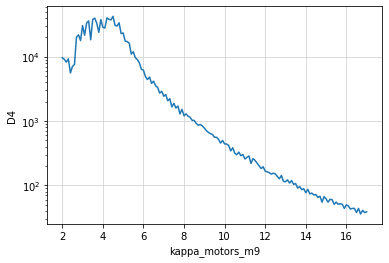

In [122]:
playsound(); plot_latest(tth_motor,D4,log=True)

In [123]:
RE(energy_plan(520))

MEG 2 520


()

sensitivity: 50 nA/V
gain: 5.0000000000000004e-08


Transient Scan ID: 166     Time: 2021-12-05 18:37:36
Persistent Unique Scan ID: '888b988c-5b9d-4ce1-8644-26801d5f1adf'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4944637715816498             |
|                    mono_energy | 520.0080234                    |
|              mono_mirror_pitch | 3.636265869140625              |
|             mono_grating_pitch | 4.9287603515625005             |
|                    centroidM3R | 110.90048573163327             |
|                kappa_motors_m2 | 1255.075                       |
|                kappa_motors_m3 | 0.026000000000000002           |
|                kappa_motors_m4 | -120.264                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.35714238179003              |
|                kappa_mot

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 519.9942602                    |
|              mono_mirror_pitch | 3.63617431640625               |
|             mono_grating_pitch | 4.928744482421875              |
|                    centroidM3R | 111.12065556393583             |
|                kappa_motors_m2 | 2255.023                       |
|                kappa_motors_m3 | 0.018000000000000002           |
|                kappa_motors_m4 | -120.26                        |
|                kappa_motors_m9 | 17.0                           |
|                kappa_motors_m8 | 65.85814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04503312                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

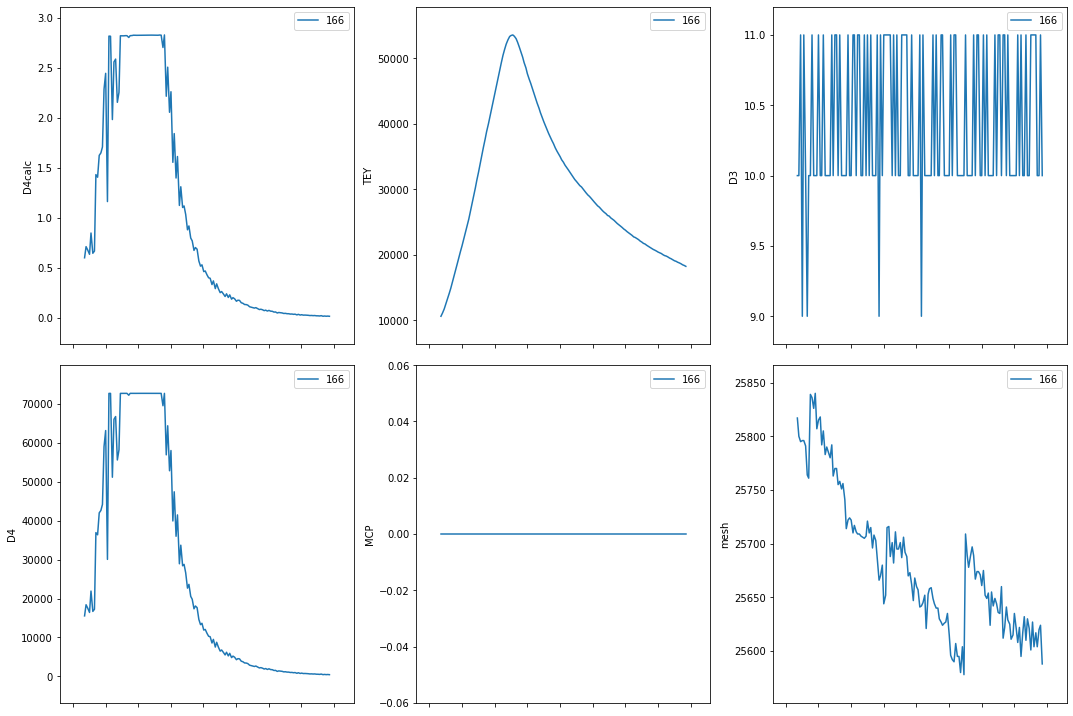

In [126]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,8.5,0.05,1500,5,komega)); slits.V4size.move(0)

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


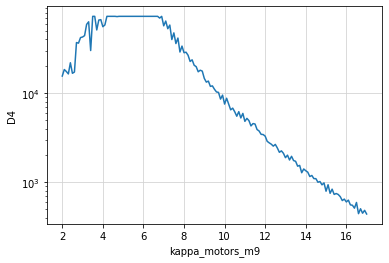

In [128]:
playsound(); plot_latest(tth_motor,D4,log=True)

In [132]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky

+-----------+------------+-----------------+------------+------------+------------+------------+------------+
generator rel_scan ['0a838c74'] (scan num: 167)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


('0a838c74-0740-41b6-8ad1-75285e8a4350',)



Transient Scan ID: 168     Time: 2021-12-05 18:46:43
Persistent Unique Scan ID: '40ffa490-5077-4cae-80ac-cad48ce7b20c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 519.9985129                    |
|              mono_mirror_pitch | 3.6361920166015627             |
|             mono_grating_pitch | 4.928722509765625              |
|                    centroidM3R | 111.2418415513824              |
|                kappa_motors_m2 | 2255.058                       |
|                kappa_motors_m3 | 0.022                          |
|                kappa_motors_m4 | -370.25600000000003            |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76100000000002             |
|       

('40ffa490-5077-4cae-80ac-cad48ce7b20c',)

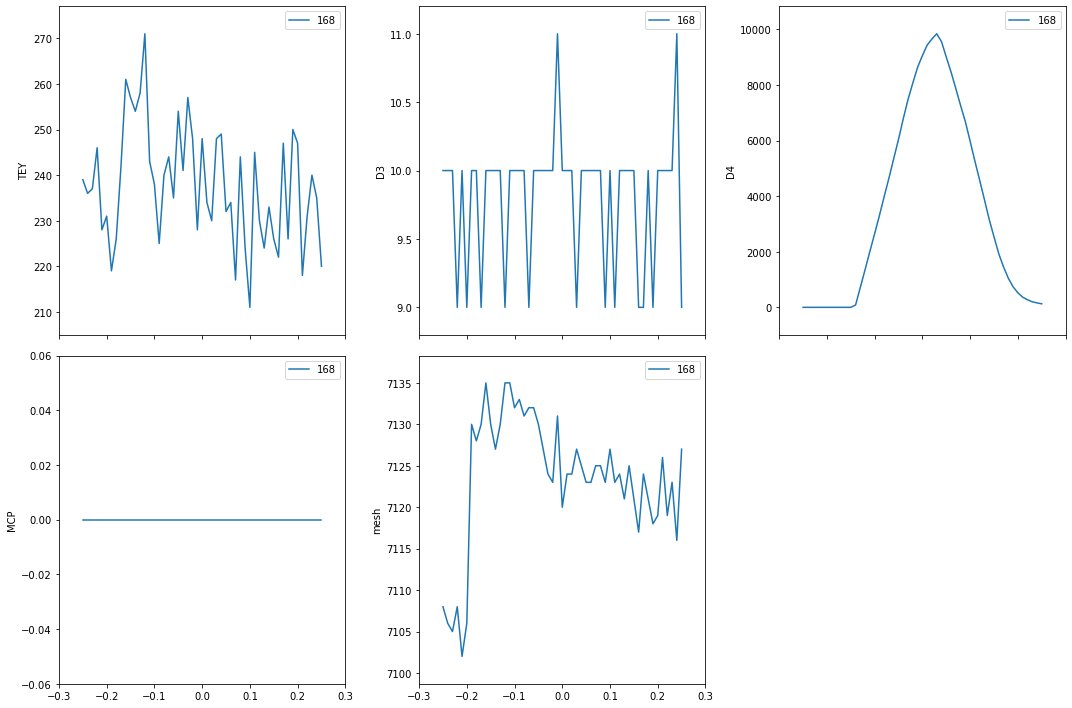

In [133]:
RE(align_tth())

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


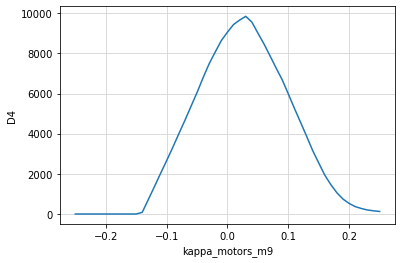

In [134]:
plot_latest(tth_motor,D4)



Transient Scan ID: 169     Time: 2021-12-05 18:48:41
Persistent Unique Scan ID: '2f008b8f-9f1c-475b-b028-9ccf5bd77675'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 520.010282                     |
|              mono_mirror_pitch | 3.6362316894531252             |
|             mono_grating_pitch | 4.92873349609375               |
|                    centroidM3R | 111.20531425651508             |
|                kappa_motors_m2 | 2255.059                       |
|                kappa_motors_m3 | 0.02                           |
|                kappa_motors_m4 | -370.266                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4944637715816498             |
|                    mono_energy | 519.9929379                    |
|              mono_mirror_pitch | 3.63624755859375               |
|             mono_grating_pitch | 4.928726782226563              |
|                    centroidM3R | 111.16678336079077             |
|                kappa_motors_m2 | 2255.06                        |
|                kappa_motors_m3 | 0.02                           |
|                kappa_motors_m4 | -370.271                       |
|                kappa_motors_m9 | 0.25                           |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04501404                    |
|                select_detector | d4                             |
|         motors_H

('2f008b8f-9f1c-475b-b028-9ccf5bd77675',)

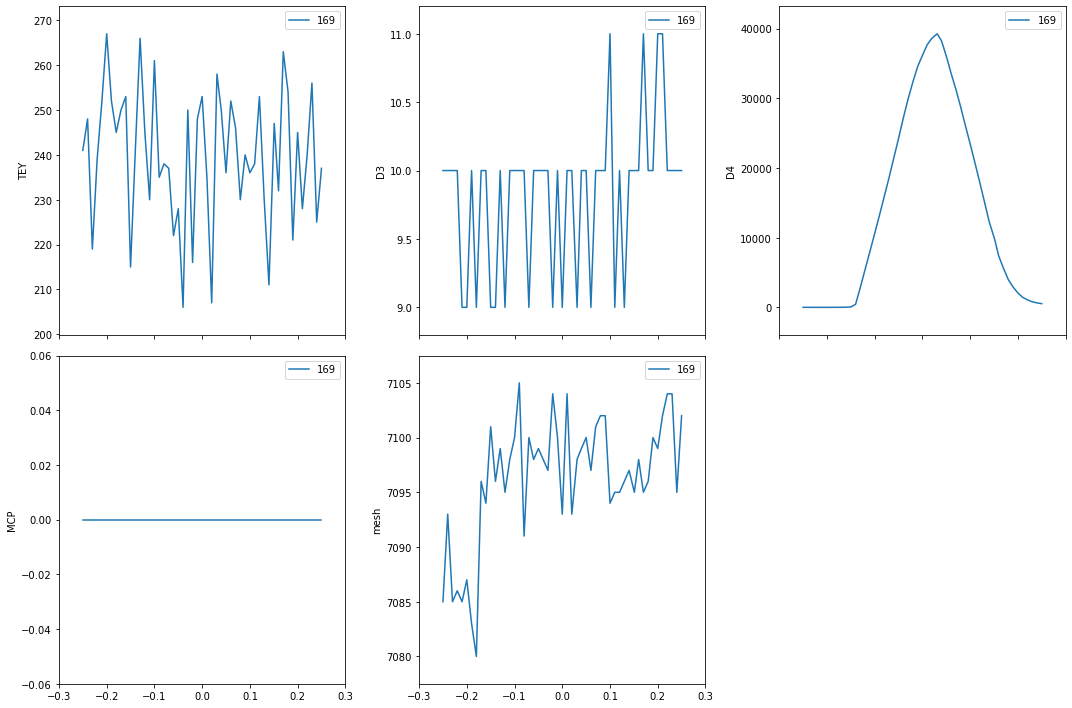

In [135]:
RE(align_tth())

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


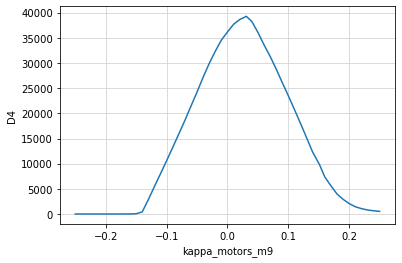

In [136]:
plot_latest(tth_motor,D4)



Transient Scan ID: 170     Time: 2021-12-05 18:50:11
Persistent Unique Scan ID: 'dbbc2151-4af0-405a-95a9-9af17b9b6438'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4944637715816498             |
|                    mono_energy | 519.9869187                    |
|              mono_mirror_pitch | 3.6361492919921874             |
|             mono_grating_pitch | 4.92873837890625               |
|                    centroidM3R | 110.07949950045197             |
|                kappa_motors_m2 | 2255.063                       |
|                kappa_motors_m3 | 0.022                          |
|                kappa_motors_m4 | -370.271                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49418091773986816            |
|                    mono_energy | 520.0076901                    |
|              mono_mirror_pitch | 3.6361822509765624             |
|             mono_grating_pitch | 4.92875302734375               |
|                    centroidM3R | 110.31202326468345             |
|                kappa_motors_m2 | 2255.063                       |
|                kappa_motors_m3 | 0.02                           |
|                kappa_motors_m4 | -370.276                       |
|                kappa_motors_m9 | 0.25                           |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04500863999999              |
|                select_detector | d4                             |
|         motors_H

('dbbc2151-4af0-405a-95a9-9af17b9b6438',)

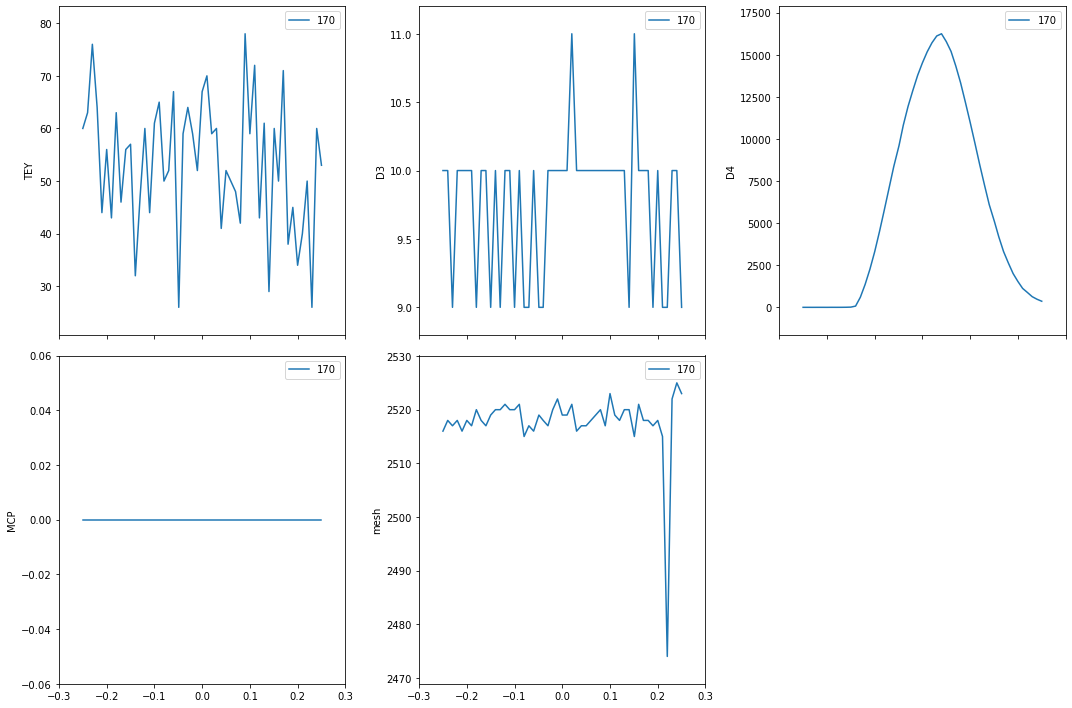

In [137]:
RE(align_tth())

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


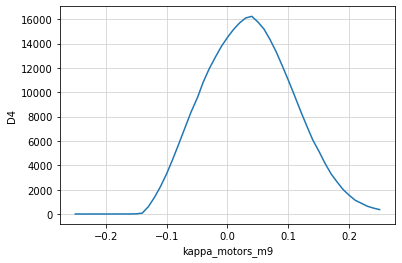

In [138]:
plot_latest(tth_motor,D4)



Transient Scan ID: 171     Time: 2021-12-05 18:52:23
Persistent Unique Scan ID: '5c0abfd7-01a3-468a-ab8e-1470b3836e34'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4942515790462494             |
|                    mono_energy | 519.9991582                    |
|              mono_mirror_pitch | 3.6362371826171875             |
|             mono_grating_pitch | 4.928732885742187              |
|                    centroidM3R | 111.31332804891858             |
|                kappa_motors_m2 | 2255.064                       |
|                kappa_motors_m3 | 0.015                          |
|                kappa_motors_m4 | -370.282                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 520.0077959                    |
|              mono_mirror_pitch | 3.63618408203125               |
|             mono_grating_pitch | 4.928738989257813              |
|                    centroidM3R | 111.14598209225886             |
|                kappa_motors_m2 | 2255.064                       |
|                kappa_motors_m3 | 0.02                           |
|                kappa_motors_m4 | -370.281                       |
|                kappa_motors_m9 | 0.25                           |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04501548                    |
|                select_detector | d4                             |
|         motors_H

('5c0abfd7-01a3-468a-ab8e-1470b3836e34',)

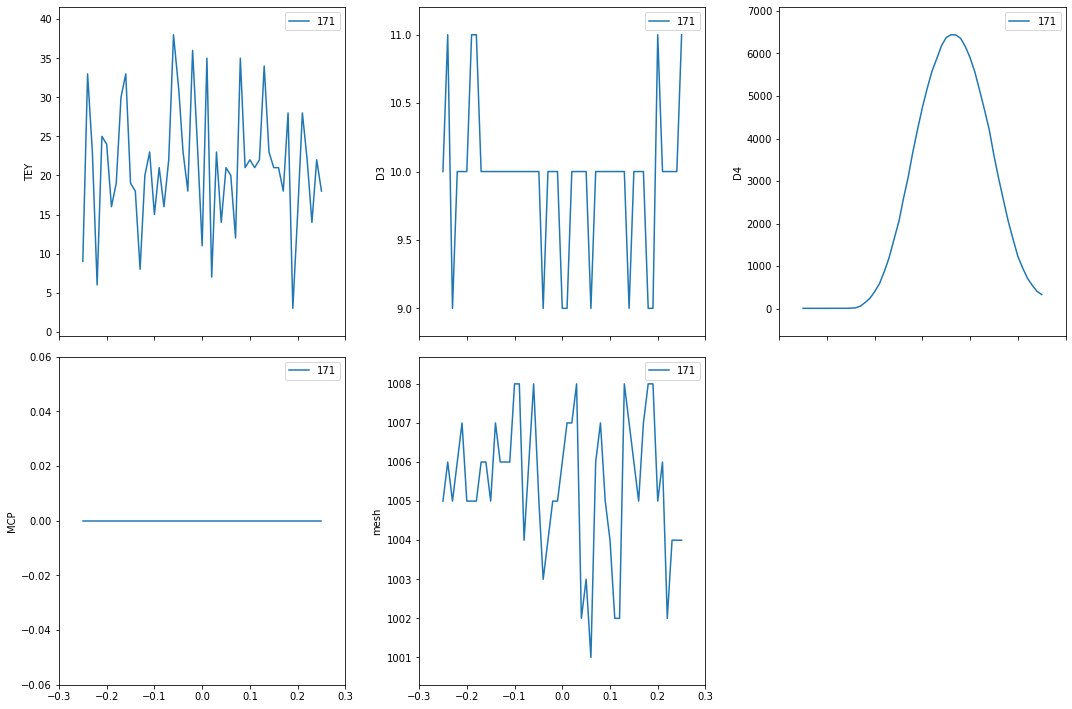

In [139]:
RE(align_tth())

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


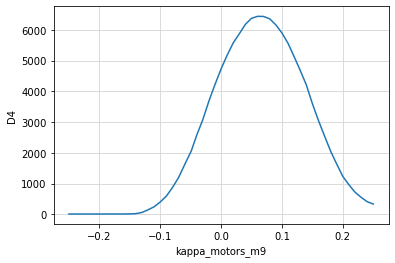

In [140]:
plot_latest(tth_motor,D4)

In [141]:
peaks

{
'com':
    {'D3': -0.0009270216962524811,
     'D4': 0.06554069255600119,
     'MCP': nan,
     'TEY': -0.0011655874190564224,
     'mesh': -4.3880177860984235e-05}
,
'cen':
    {'D3': -0.030000000000000027,
     'D4': 0.0645804457834232,
     'MCP': None,
     'TEY': -0.0027292301266852617,
     'mesh': 0.03391666666666667}
,
'max':
    {'D3': (-0.24,
            11.0),
     'D4': (0.06,
            6439.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (-0.06,
             38.0),
     'mesh': (-0.1,
              1008.0)}
,
'min':
    {'D3': (-0.23,
            9.0),
     'D4': (-0.25,
            8.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.19,
             3.0),
     'mesh': (0.06,
              1001.0)}
,
'fwhm':
    {'D3': 0.49,
     'D4': 0.1844092359377073,
     'MCP': None,
     'TEY': 0.48895833333333333,
     'mesh': 0.295}
,
}

In [142]:
RE(mvtth(0.065))

()



Transient Scan ID: 172     Time: 2021-12-05 18:54:49
Persistent Unique Scan ID: '326b1ee0-6334-4e12-9de6-73f7515e4075'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4944637715816498             |
|                    mono_energy | 519.9985499                    |
|              mono_mirror_pitch | 3.636259765625                 |
|             mono_grating_pitch | 4.92876767578125               |
|                    centroidM3R | 111.48696048286072             |
|                kappa_motors_m2 | 2255.064                       |
|                kappa_motors_m3 | 0.02                           |
|                kappa_motors_m4 | -370.283                       |
|                kappa_motors_m9 | 0.065                          |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 520.0078964                    |
|              mono_mirror_pitch | 3.6362426757812503             |
|             mono_grating_pitch | 4.928732885742187              |
|                    centroidM3R | 111.37234405181229             |
|                kappa_motors_m2 | 2255.067                       |
|                kappa_motors_m3 | 0.014                          |
|                kappa_motors_m4 | -370.283                       |
|                kappa_motors_m9 | 0.315                          |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76100000000002             |
|                kappa_motors_m1 | 57.04501548                    |
|                select_detector | d4                             |
|         motors_H

('326b1ee0-6334-4e12-9de6-73f7515e4075',)

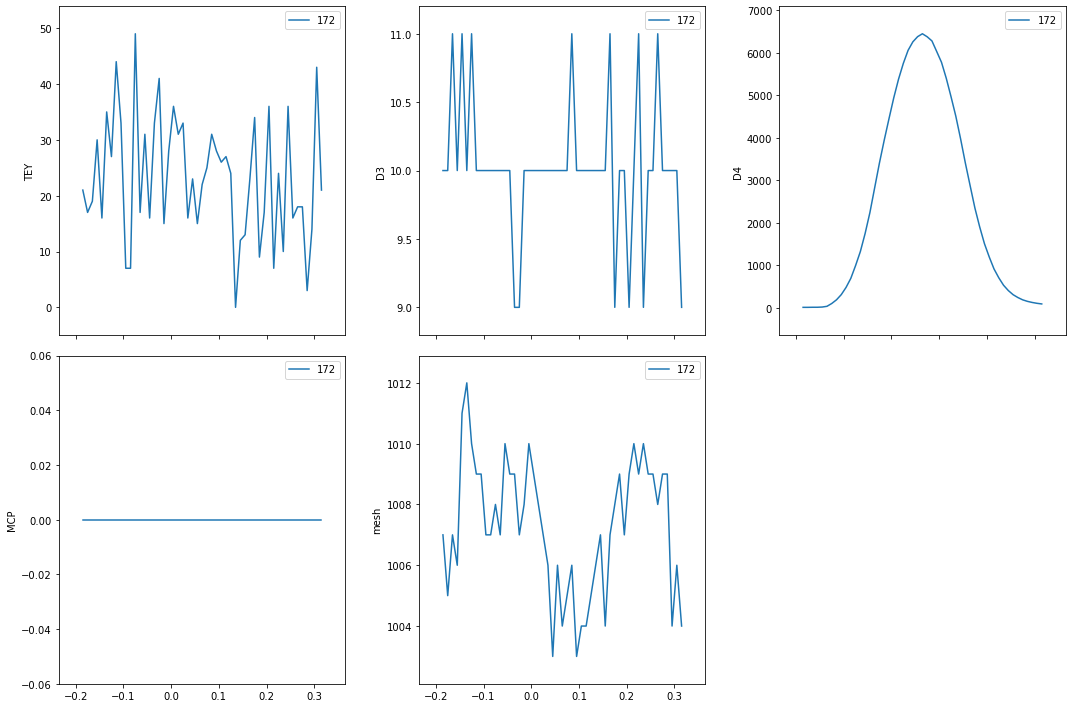

In [143]:
RE(align_tth())

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


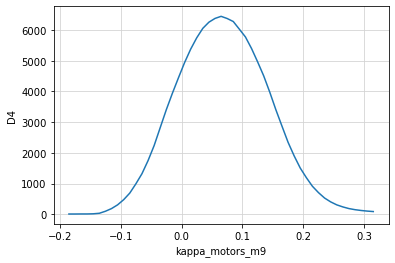

In [144]:
plot_latest(tth_motor,D4)

In [145]:
peaks

{
'com':
    {'D3': 0.06376712328767123,
     'D4': 0.06870049265842351,
     'MCP': nan,
     'TEY': 0.05027612574341546,
     'mesh': 0.06495075138207582}
,
'cen':
    {'D3': 0.04285714285714285,
     'D4': 0.0651185613046338,
     'MCP': None,
     'TEY': 0.054769937170601767,
     'mesh': 0.029805555555555557}
,
'max':
    {'D3': (-0.165,
            11.0),
     'D4': (0.065,
            6447.0),
     'MCP': (-0.185,
             0.0),
     'TEY': (-0.075,
             49.0),
     'mesh': (-0.135,
              1012.0)}
,
'min':
    {'D3': (-0.035,
            9.0),
     'D4': (-0.185,
            8.0),
     'MCP': (-0.185,
             0.0),
     'TEY': (0.135,
             0.0),
     'mesh': (0.045,
              1003.0)}
,
'fwhm':
    {'D3': 0.45000000000000007,
     'D4': 0.18636062175163468,
     'MCP': None,
     'TEY': 0.4734090909090909,
     'mesh': 0.44000000000000006}
,
}

In [146]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [147]:
RE(mvtth(0.06511))

()

In [148]:
RE(tth0_set())

()



Transient Scan ID: 173     Time: 2021-12-05 18:57:59
Persistent Unique Scan ID: '01ef3a9e-c0ef-4e67-9063-8715817284ce'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4943222999572754             |
|                    mono_energy | 519.9984018                    |
|              mono_mirror_pitch | 3.6362347412109375             |
|             mono_grating_pitch | 4.928745703125                 |
|                    centroidM3R | 111.45834274102506             |
|                kappa_motors_m2 | 2255.068                       |
|                kappa_motors_m3 | 0.023                          |
|                kappa_motors_m4 | 130.059                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 520.0018611                    |
|              mono_mirror_pitch | 3.6361871337890626             |
|             mono_grating_pitch | 4.928753637695313              |
|                    centroidM3R | 111.13669064748201             |
|                kappa_motors_m2 | 2255.068                       |
|                kappa_motors_m3 | 0.025                          |
|                kappa_motors_m4 | 880.058                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.35814238179                 |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.04501548                    |
|                select_detector | d3                             |
|         motors_H

('01ef3a9e-c0ef-4e67-9063-8715817284ce',)

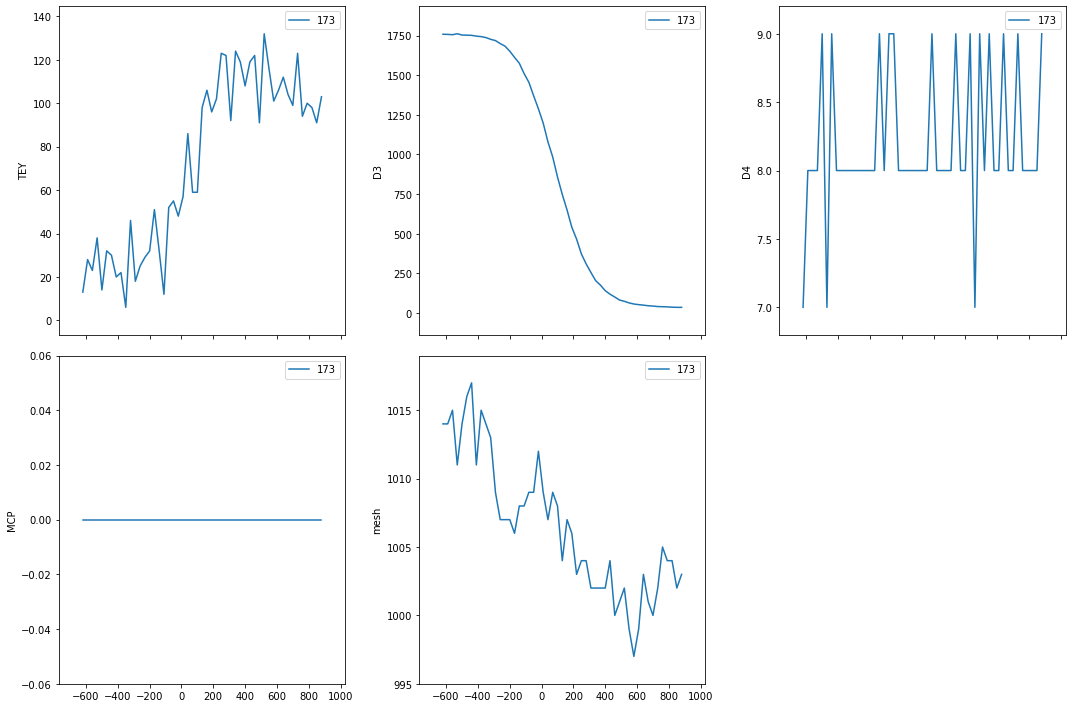

In [150]:
RE(align_z())

In [151]:
find_z()

Array is :  [1758. 1757. 1755. 1761. 1753. 1752. 1751. 1746. 1743. 1737. 1726. 1718.
 1699. 1683. 1651. 1612. 1575. 1510. 1455. 1370. 1288. 1198. 1079.  984.
  858.  748.  650.  541.  466.  373.  310.  256.  204.  176.  141.  119.
  101.   82.   74.   64.   57.   53.   50.   46.   44.   41.   40.   39.
   37.   36.   36.]
Value to which nearest element is to be found:  862.5
Nearest element to the given values is :  858.0
Index of nearest value is :  24
Corresponding motor position of nearest value is :  100.055




Transient Scan ID: 176     Time: 2021-12-05 19:04:22
Persistent Unique Scan ID: 'c6b32b7b-54ce-4260-a95a-92c5193b4759'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4944637715816498             |
|                    mono_energy | 519.9918483                    |
|              mono_mirror_pitch | 3.63623779296875               |
|             mono_grating_pitch | 4.92875546875                  |
|                    centroidM3R | 110.92543859649123             |
|                kappa_motors_m2 | 2255.074                       |
|                kappa_motors_m3 | 0.007                          |
|                kappa_motors_m4 | -900.27                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.04814238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

('c6b32b7b-54ce-4260-a95a-92c5193b4759',)

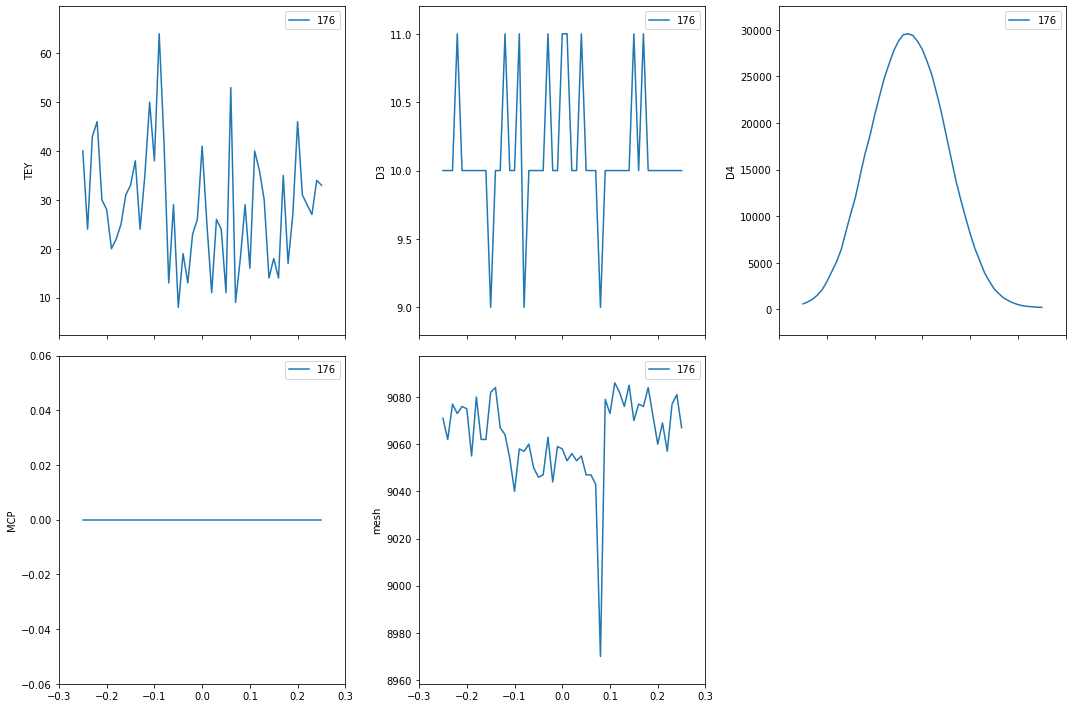

In [159]:
RE(align_tth())

In [160]:
peaks

{
'com':
    {'D3': 0.00011627906976745095,
     'D4': -0.029132770326212948,
     'MCP': nan,
     'TEY': -0.01027434842249658,
     'mesh': 1.4278883910527896e-05}
,
'cen':
    {'D3': -0.012187500000000004,
     'D4': -0.03121608678064454,
     'MCP': None,
     'TEY': -0.02836169872172593,
     'mesh': 0.07868794771898957}
,
'max':
    {'D3': (-0.22,
            11.0),
     'D4': (-0.03,
            29569.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (-0.09,
             64.0),
     'mesh': (0.11,
              9086.0)}
,
'min':
    {'D3': (-0.15,
            9.0),
     'D4': (0.25,
            224.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (-0.05,
             8.0),
     'mesh': (0.08,
              8970.0)}
,
'fwhm':
    {'D3': 0.41000000000000003,
     'D4': 0.1939019021625417,
     'MCP': None,
     'TEY': 0.45416666666666666,
     'mesh': 0.01326630639688324}
,
}

In [161]:
RE(mvtth(-0.031))

()

In [162]:
RE(tth0_set())

()



Transient Scan ID: 177     Time: 2021-12-05 19:05:44
Persistent Unique Scan ID: 'b6951473-5a0e-426d-b70f-f823f8cff637'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49418091773986816            |
|                    mono_energy | 519.9972011                    |
|              mono_mirror_pitch | 3.6362103271484374             |
|             mono_grating_pitch | 4.928736547851563              |
|                    centroidM3R | 111.018835120255               |
|                kappa_motors_m2 | 2255.073                       |
|                kappa_motors_m3 | 0.011                          |
|                kappa_motors_m4 | -900.2860000000001             |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.04814238179003              |
|                kappa_motors_m7 | 134.76100000000002             |
|       

('b6951473-5a0e-426d-b70f-f823f8cff637',)

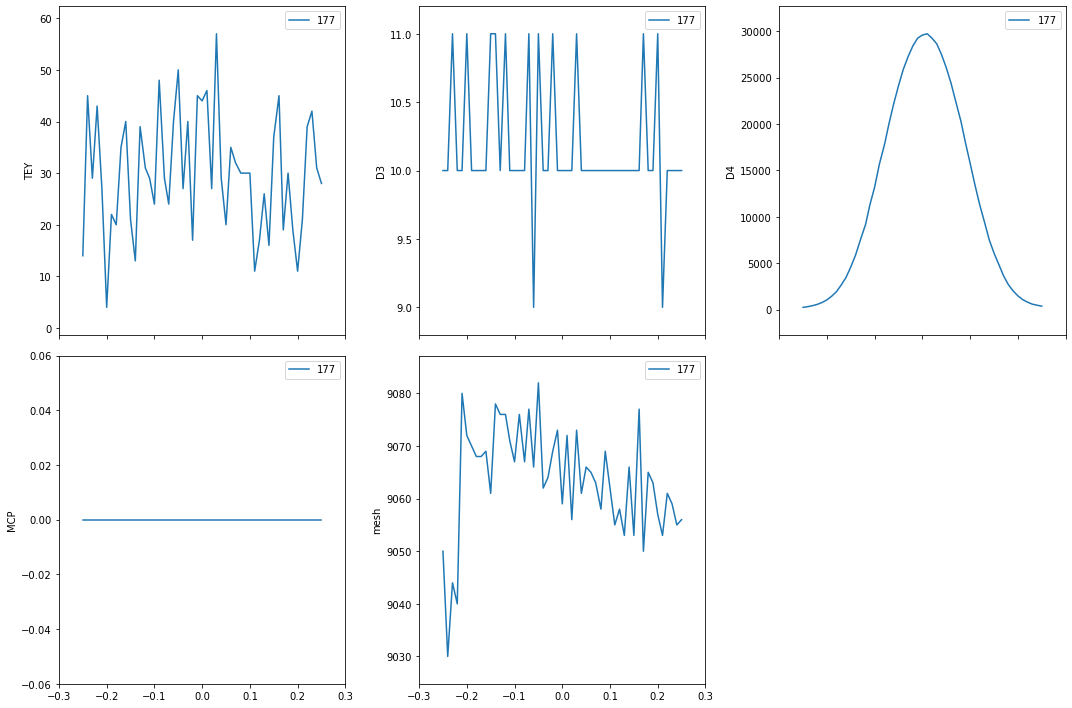

In [163]:
RE(align_tth())

In [164]:
peaks

{
'com':
    {'D3': -0.0014065510597302475,
     'D4': 0.005397064321432481,
     'MCP': nan,
     'TEY': -0.0014463350785340265,
     'mesh': -2.221784739994334e-05}
,
'cen':
    {'D3': -0.04365000000000001,
     'D4': 0.005254766005686251,
     'MCP': None,
     'TEY': -0.0364090872133249,
     'mesh': 0.11407355442176872}
,
'max':
    {'D3': (-0.23,
            11.0),
     'D4': (0.01,
            29734.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (0.03,
             57.0),
     'mesh': (-0.05,
              9082.0)}
,
'min':
    {'D3': (-0.06,
            9.0),
     'D4': (-0.25,
            233.0),
     'MCP': (-0.25,
             0.0),
     'TEY': (-0.2,
             4.0),
     'mesh': (-0.24,
              9030.0)}
,
'fwhm':
    {'D3': 0.445,
     'D4': 0.19629115973095349,
     'MCP': None,
     'TEY': 0.48634408602150536,
     'mesh': 0.4535}
,
}

In [165]:
RE(mvtth(0.005))

()

In [166]:
RE(tth0_set())

()



Transient Scan ID: 178     Time: 2021-12-05 19:07:48
Persistent Unique Scan ID: 'f2f4ce82-fa2d-4005-bd47-eef0528c4dc6'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49418091773986816            |
|                    mono_energy | 519.9966827                    |
|              mono_mirror_pitch | 3.6361907958984374             |
|             mono_grating_pitch | 4.928753637695313              |
|                    centroidM3R | 111.0763413929294              |
|                kappa_motors_m2 | 2255.074                       |
|                kappa_motors_m3 | 0.018000000000000002           |
|                kappa_motors_m4 | 100.089                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.04814238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

('f2f4ce82-fa2d-4005-bd47-eef0528c4dc6',)

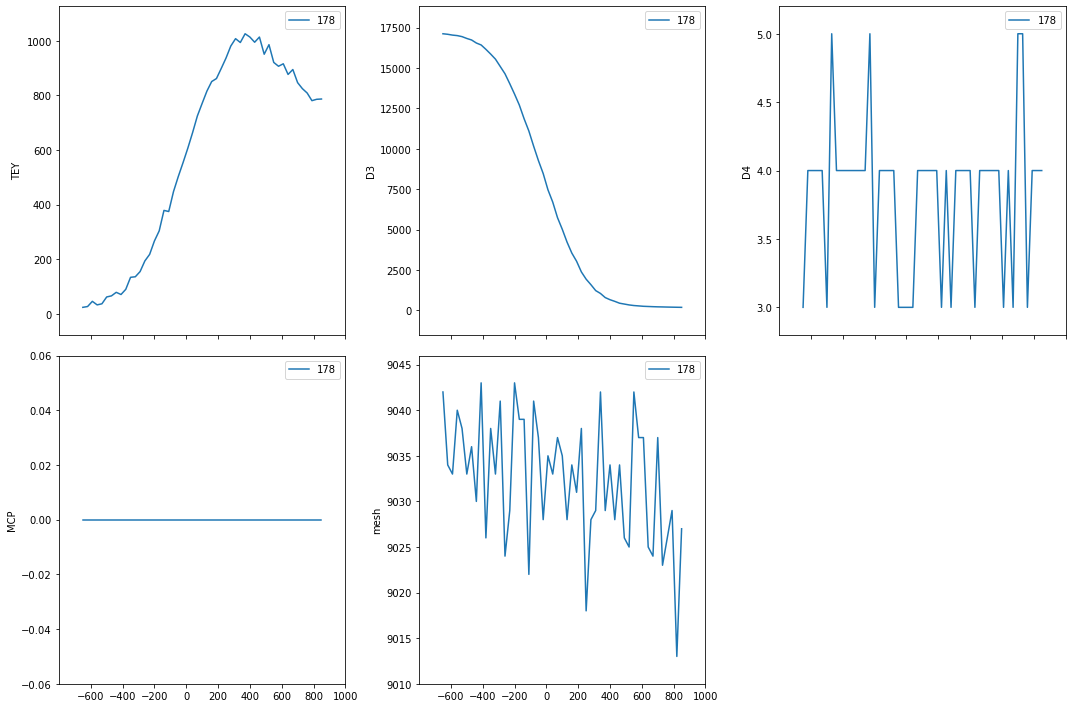

In [167]:
RE(align_z())

In [169]:
find_z()

Array is :  [17119. 17086. 17036. 17005. 16941. 16828. 16734. 16546. 16426. 16154.
 15862. 15549. 15096. 14642. 14028. 13387. 12709. 11864. 11102. 10165.
  9275.  8472.  7465.  6706.  5743.  5022.  4228.  3551.  3043.  2385.
  1935.  1595.  1229.  1052.   797.   665.   563.   449.   396.   342.
   305.   282.   258.   246.   234.   224.   218.   210.   204.   198.
   193.]
Value to which nearest element is to be found:  8463.0
Nearest element to the given values is :  8472.0
Index of nearest value is :  21
Corresponding motor position of nearest value is :  -19.916


In [171]:
RE.abort()     

Aborting: running cleanup and marking exit_status as 'abort'...


Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky

+-----------+------------+-----------------+------------+------------+------------+------------+------------+
generator rel_scan ['14a447bf'] (scan num: 179)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


('14a447bf-349a-4029-9241-a21a4ae0faaf',)



Transient Scan ID: 180     Time: 2021-12-05 19:10:33
Persistent Unique Scan ID: '0eb1b248-8315-49ce-bee7-a22d3c0900c2'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4943930506706238             |
|                    mono_energy | 520.008674                     |
|              mono_mirror_pitch | 3.6362432861328124             |
|             mono_grating_pitch | 4.928737768554687              |
|                    centroidM3R | 111.0983685451658              |
|                kappa_motors_m2 | 2255.088                       |
|                kappa_motors_m3 | 0.003                          |
|                kappa_motors_m4 | -20.129                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.04814238179003              |
|                kappa_motors_m7 | 134.76                         |
|       

('0eb1b248-8315-49ce-bee7-a22d3c0900c2',)

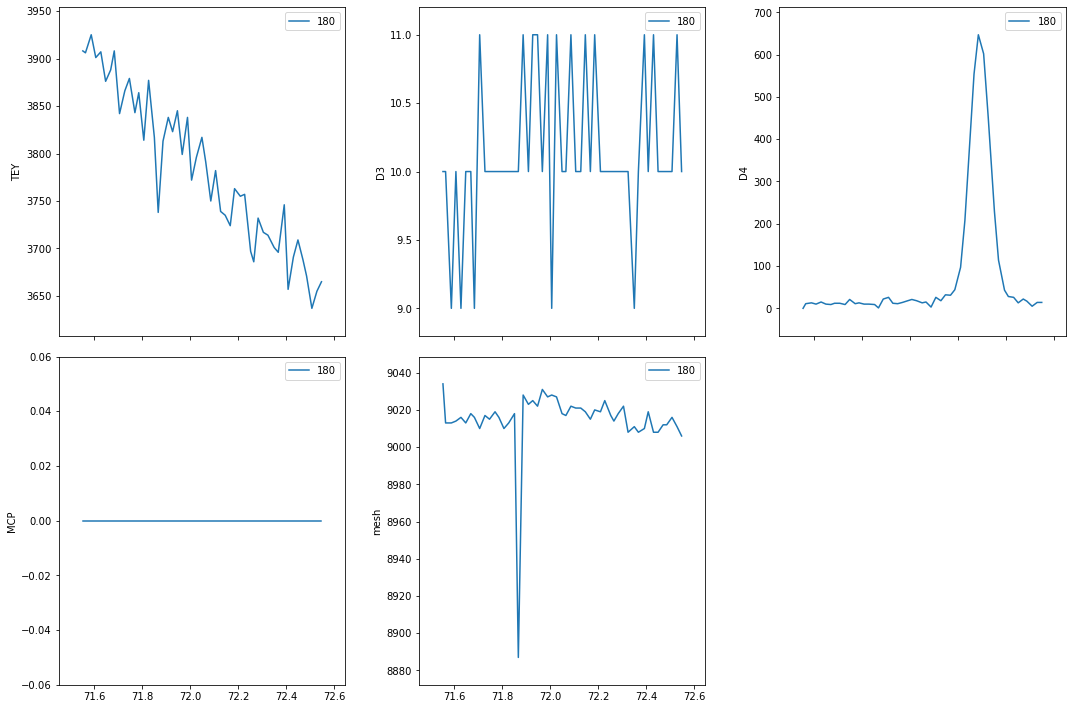

In [172]:
RE(align_kth(0.5))

In [173]:
peaks

{
'com':
    {'D3': 72.05171104716719,
     'D4': 72.25495188191435,
     'MCP': nan,
     'TEY': 72.0422973792506,
     'mesh': 72.04913077548223}
,
'cen':
    {'D3': 72.11975601815364,
     'D4': 72.28951813894861,
     'MCP': None,
     'TEY': 72.00527451713312,
     'mesh': 71.86786659812915}
,
'max':
    {'D3': (71.70614238179002,
            11.0),
     'D4': (72.28314238179001,
            647.0),
     'MCP': (71.55314238179002,
             0.0),
     'TEY': (71.58814238179002,
             3925.0),
     'mesh': (71.55314238179002,
              9034.0)}
,
'min':
    {'D3': (71.58814238179002,
            9.0),
     'D4': (71.55314238179002,
            0.0),
     'MCP': (71.55314238179002,
             0.0),
     'TEY': (72.50714238179,
             3637.0),
     'mesh': (71.86714238179002,
              8887.0)}
,
'fwhm':
    {'D3': 0.8520000000000039,
     'D4': 0.09931098568283403,
     'MCP': None,
     'TEY': 0.2481972328525046,
     'mesh': 0.019402631151535843}
,
}

In [174]:
RE(mvkth(72.283))

()



Transient Scan ID: 181     Time: 2021-12-05 19:12:28
Persistent Unique Scan ID: 'b33f9a0b-ee1d-4084-99bd-9259388e4b39'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 520.0073939                    |
|              mono_mirror_pitch | 3.6362121582031253             |
|             mono_grating_pitch | 4.9287408203125                |
|                    centroidM3R | 111.08528774379967             |
|                kappa_motors_m2 | 2255.085                       |
|                kappa_motors_m3 | -0.002                         |
|                kappa_motors_m4 | -20.147000000000002            |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.28314238179001              |
|                kappa_motors_m7 | 134.76                         |
|       

('b33f9a0b-ee1d-4084-99bd-9259388e4b39',)

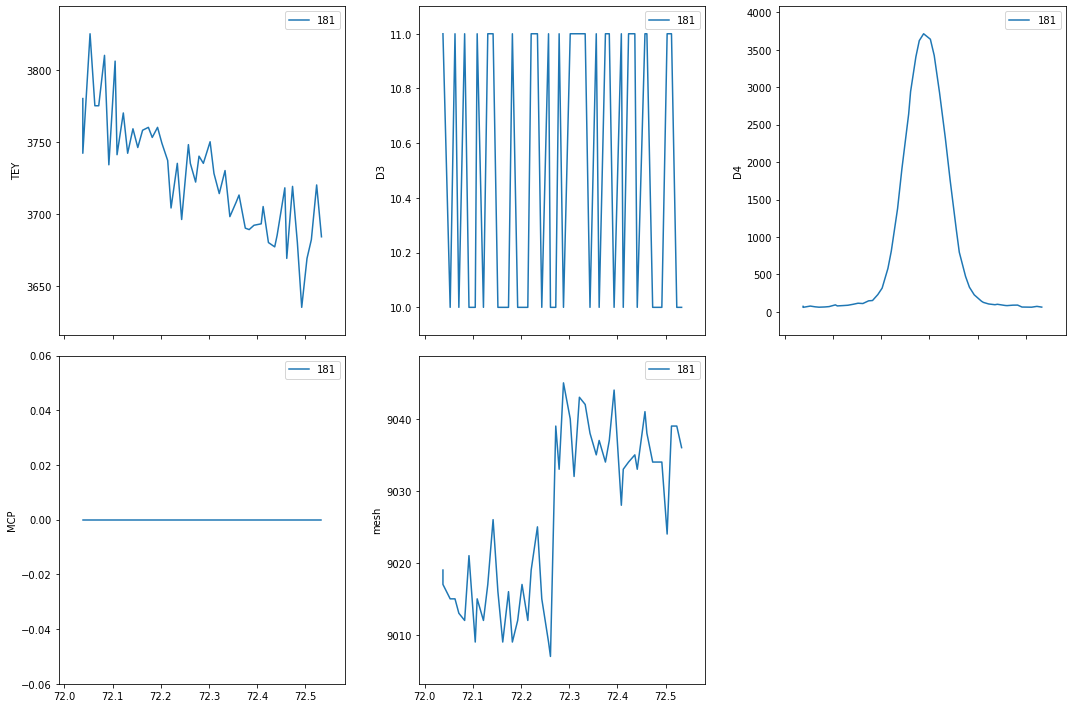

In [175]:
RE(align_kth(0.25))

In [176]:
peaks

{
'com':
    {'D3': 72.27914238179002,
     'D4': 72.28615723519442,
     'MCP': nan,
     'TEY': 72.27824005890048,
     'mesh': 72.27926987289439}
,
'cen':
    {'D3': 72.27162625275778,
     'D4': 72.2918132844456,
     'MCP': None,
     'TEY': 72.25504386382053,
     'mesh': 72.42431946512335}
,
'max':
    {'D3': (72.03814238179001,
            11.0),
     'D4': (72.28814238179001,
            3714.0),
     'MCP': (72.03814238179001,
             0.0),
     'TEY': (72.05314238179002,
             3825.0),
     'mesh': (72.28814238179001,
              9045.0)}
,
'min':
    {'D3': (72.05314238179002,
            10.0),
     'D4': (72.03814238179001,
            61.0),
     'MCP': (72.03814238179001,
             0.0),
     'TEY': (72.49214238179002,
             3635.0),
     'mesh': (72.26114238179002,
              9007.0)}
,
'fwhm':
    {'D3': 0.4720000000000084,
     'D4': 0.09813691809310399,
     'MCP': None,
     'TEY': 0.09378787878787875,
     'mesh': 0.23666874999999266}
,


In [177]:
komega=72.2918-15

In [178]:
komega

57.291799999999995

In [181]:
komega-57.045

0.24679999999999325

In [182]:
a=2
RE(uank(a,a/2+komega))

()

sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


Transient Scan ID: 182     Time: 2021-12-05 19:18:15
Persistent Unique Scan ID: '38337488-9c15-433b-950c-98160b224846'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49453452229499817            |
|                    mono_energy | 520.003395                     |
|              mono_mirror_pitch | 3.6362445068359377             |
|             mono_grating_pitch | 4.9287426513671875             |
|                    centroidM3R | 111.11385016160934             |
|                kappa_motors_m2 | 2255.078                       |
|                kappa_motors_m3 | 0.014                          |
|                kappa_motors_m4 | -20.172                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.29214238179003              |
|                kappa_mo

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

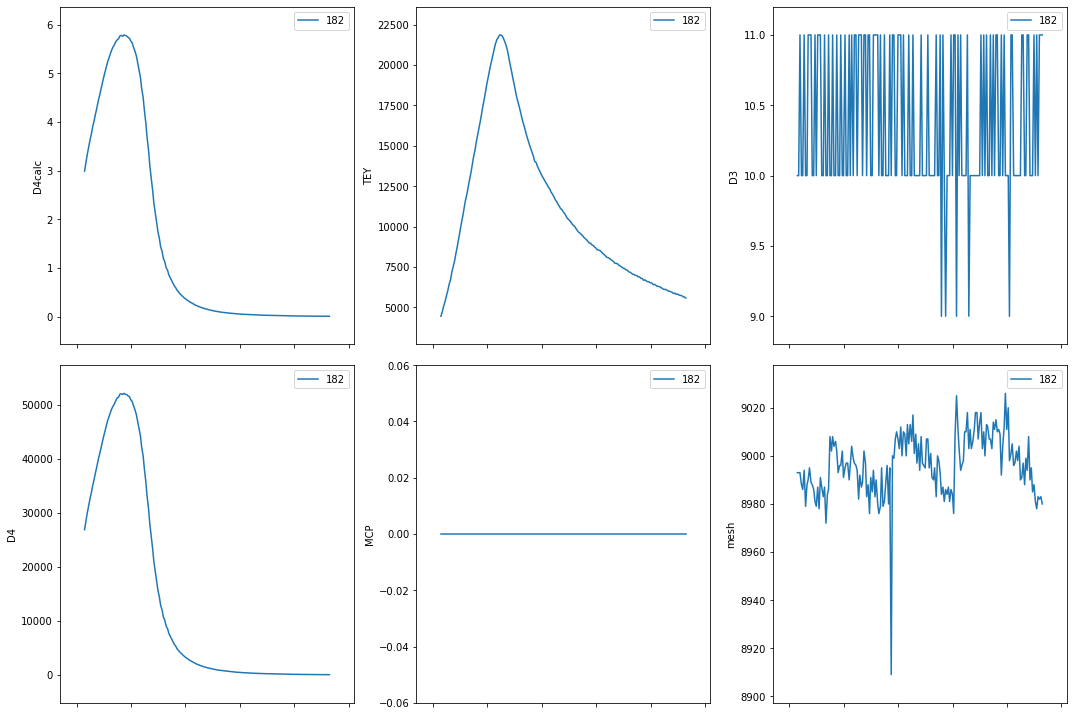

In [183]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,2500,5,komega)); slits.V4size.move(0)

sensitivity: 500 pA/V
gain: 5e-10


Transient Scan ID: 183     Time: 2021-12-05 19:27:46
Persistent Unique Scan ID: '22b897a1-0bbb-4877-9940-d2f8b2d80411'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4943222999572754             |
|                    mono_energy | 520.0002848                    |
|              mono_mirror_pitch | 3.636241455078125              |
|             mono_grating_pitch | 4.92874814453125               |
|                    centroidM3R | 110.906854298296               |
|                kappa_motors_m2 | 3405.061                       |
|                kappa_motors_m3 | 0.005                          |
|                kappa_motors_m4 | -20.184                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.29214238179003              |
|                kappa_motors_m7 | 134.76 

MoveStatus(done=True, pos=motors_V4size, elapsed=1.0, success=True, settle_time=0.0)

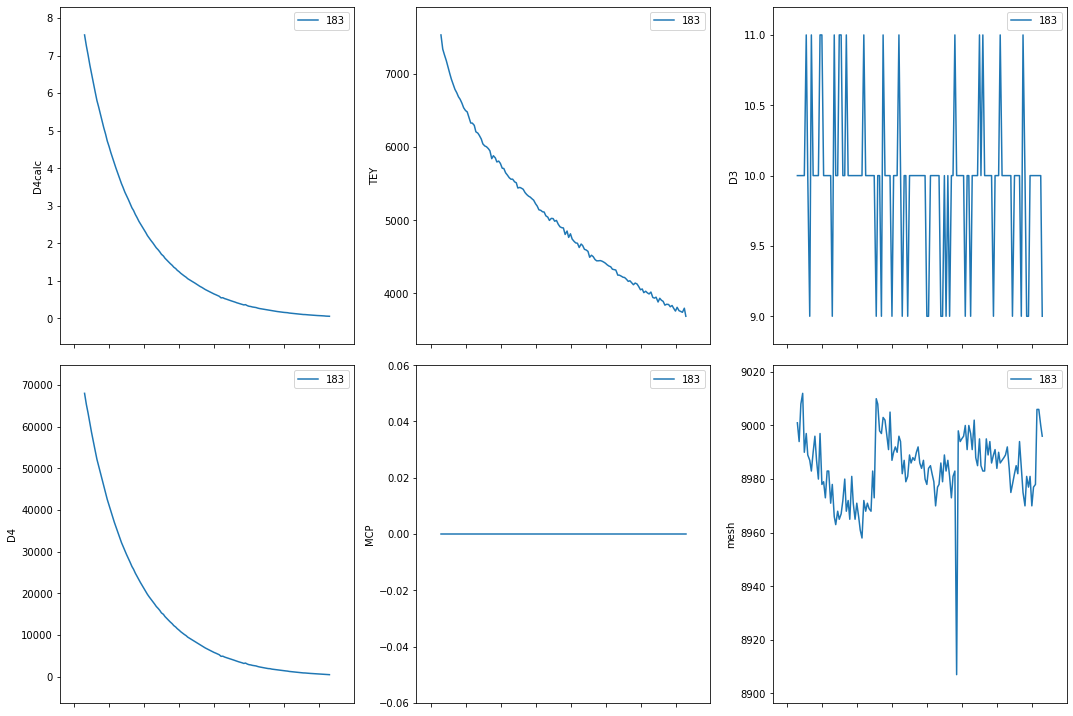

In [184]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(8,15,0.05,3700,5,komega)); slits.V4size.move(0)

In [ ]:
playsound()

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


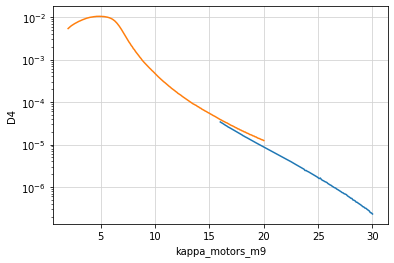

In [185]:
plot_reflectivity()

In [186]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [188]:
a=2
RE(uank(a,a/2+komega))

()

sensitivity: 100 nA/V
gain: 1.0000000000000001e-07


Transient Scan ID: 184     Time: 2021-12-05 19:33:44
Persistent Unique Scan ID: '4a211efd-e82b-4599-8758-71ada6d05b72'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4942515790462494             |
|                    mono_energy | 519.9915204                    |
|              mono_mirror_pitch | 3.6361676025390626             |
|             mono_grating_pitch | 4.9287426513671875             |
|                    centroidM3R | 111.81382373035756             |
|                kappa_motors_m2 | 4405.072                       |
|                kappa_motors_m3 | 0.021                          |
|                kappa_motors_m4 | -20.193                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.29214238179003              |
|                kappa_mo

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4944637715816498             |
|                    mono_energy | 520.0071771                    |
|              mono_mirror_pitch | 3.636241455078125              |
|             mono_grating_pitch | 4.928762182617188              |
|                    centroidM3R | 111.94086697929772             |
|                kappa_motors_m2 | 5605.02                        |
|                kappa_motors_m3 | 0.007                          |
|                kappa_motors_m4 | -20.195                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.29114238179002              |
|                kappa_motors_m7 | 134.76                         |
|                kappa_motors_m1 | 57.044983079999994             |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

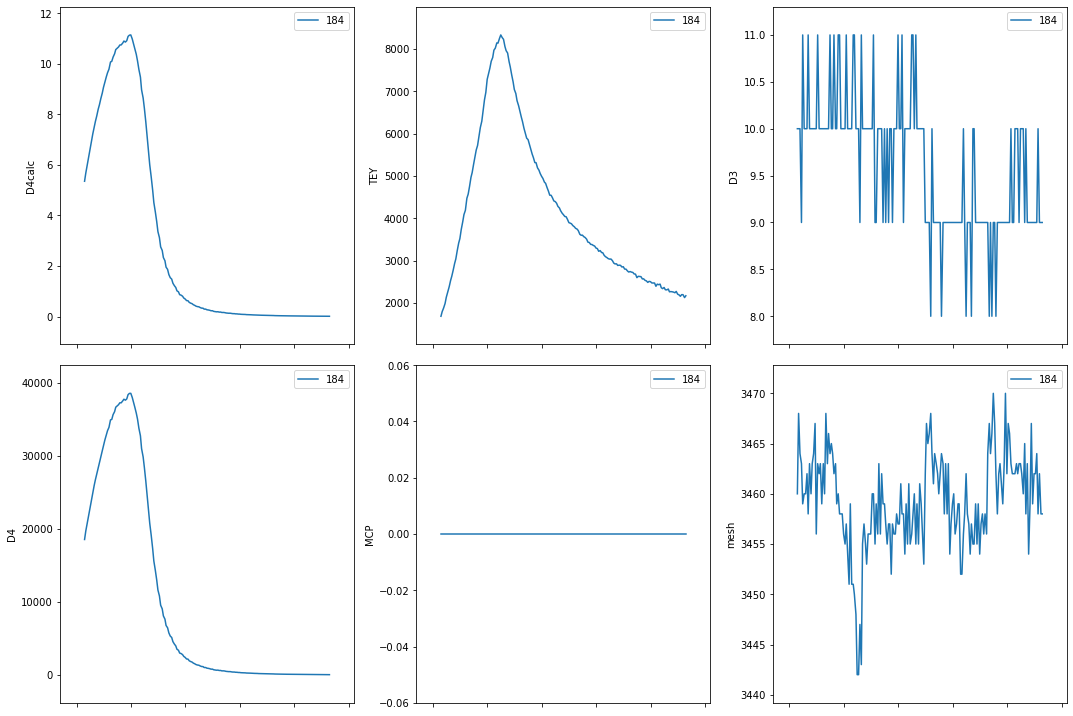

In [189]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,4700,5,komega)); slits.V4size.move(0)

In [190]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo
